<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Connect Google Drive

In [ ]:
from google.colab import drive, files

In [ ]:
import os
import sys

In [13]:
is_colab = 'google.colab' in sys.modules

if is_colab:
    base_path = "/content/drive/.shortcut-targets-by-id/1hNB4s6RR7JeKfFdGwm27WrF6pNXXIg3R/Deep Learning"
    drive.mount('/content/drive')

    os.chdir('/content/drive/MyDrive/Deep Learning')
    print("Changed directory to:", os.getcwd())
    !pip install keras_cv
    !pip install -q -U keras-tuner
else:
    base_path = ".."

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Changed directory to: /content/drive/.shortcut-targets-by-id/1hNB4s6RR7JeKfFdGwm27WrF6pNXXIg3R/Deep Learning


## 1.2 Import Libraries

In [ ]:
from classes import *
from functions import *

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import zipfile
import pickle
from pathlib import Path

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

# keras
from keras_tuner import Hyperband, Objective
from tensorflow import keras
from keras import regularizers

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
# tensorflow - layers
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten, BatchNormalization, Activation,
    ReLU, LeakyReLU, Add, Concatenate, concatenate)


## 1.3 Import Dataset

In [ ]:
#Load the DataFrames from the .pkl files
with open(os.path.join(base_path,"data/train_df.pkl"), "rb") as f:
     train_df = pickle.load(f)

with open(os.path.join(base_path,"data/valid_df.pkl"), "rb") as f:
     val_df = pickle.load(f)

with open(os.path.join(base_path,"data/test_df.pkl"), "rb") as f:
     test_df = pickle.load(f)

with open(os.path.join(base_path,"data/train_df_sampled.pkl"), "rb") as f:
     train_df_sampled = pickle.load(f)

# with open("../data/family_encoder.pkl", "rb") as f:
#     family_encoder = pickle.load(f)

<div class="alert alert-block alert-success">

# **2.** Preprocessing

<div>

- Normalizes pixel values (e.g., rescaling from [0,255] to [0,1]).
- Resizes images to a fixed size (e.g., 224x224 pixels).
- Applies augmentation (only during training).
- Converts images to batches (e.g., batch_size=32 loads 32 images at a time).

In [ ]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

In [ ]:
# batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
# image_size = (224, 224)

# preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# train_ds, class_names = preprocess.load_img(data_dir="../data/rare_species/train", minority_class=minority_class, augment=None, oversampling=True)
# train_ds_sampled, class_names = preprocess.load_img(data_dir="../data/rare_species/train_sampled", minority_class=minority_class, augment=None, oversampling=True)
# val_ds, _ = preprocess.load_img(data_dir="../data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
# test_ds, _ = preprocess.load_img(data_dir="../data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

In [ ]:
# num_images = 32 ##
# # rows, cols = 8, 4 ##

# plot_batch(train_ds, class_names=class_names, num_images=num_images, rows=rows, cols=cols)

<div class="alert alert-block alert-success">

# **3.** Parameters

<div>

In [ ]:
# Add callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    , EarlyStopping(patience=7, restore_best_weights=True, monitor="val_loss", verbose=1)
]

In [ ]:
augmentations_to_test = [
    "none",
    "medium",
    "light",
    "mixup",
    "heavy",
    "grayscale_plus",
    "randaugment",
    "color_lightening",
    "geometric_transformations"
    ]

In [ ]:
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_macro"),
    F1Score(average="weighted", name="f1_weighted"),
    TopKCategoricalAccuracy(k=5, name="top5_accuracy")
]

<div class="alert alert-block alert-success">

# **4.** Models

<div>

## 4.1 Architectures

### 4.1.1 Convolutional Baseline

In [ ]:
def build_baseline(input_shape=(224, 224, 3), num_classes=202):
  # by calling Sequential:
  model = Sequential(
      layers = [
          Input(shape=input_shape),
          Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu"),
          MaxPooling2D(pool_size=(2, 2)),
          Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu"),
          MaxPooling2D(pool_size=(2, 2)),
          Flatten(),
          Dropout(0.5),
          Dense(num_classes, activation="softmax"),
      ]
  )
  return model

model = build_baseline()

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 24)   │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 48)   │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 139968)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 139968)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 202)            │    28,273,738 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,284,826 (107.90 MB)

 Trainable params: 28,284,826 (107.90 MB)

 Non-trainable params: 0 (0.00 B)

### 4.1.2 GoogLeNet

Uses Inception modules to capture multi-scale features

- Good balance of depth and efficiency.
- Excellent at capturing fine-grained details (your dataset has many classes with subtle visual differences).
- Faster to train than ResNet or Transformers.

GoogleNet/Inception is a large model designed to be trained on millions of images (e.g. ImageNet’s 1.2 M). With only a few dozen examples per class it simply can’t learn good feature filters from scratch. Result: the loss barely moves, accuracy plateaus just above random chance (~0.5%) because it “sees” too few unique examples to carve out 202 decision boundaries.

In [ ]:
def inception_module(x, f1, f3_in, f3_out, f5_in, f5_out, pool_proj):
    path1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    path2 = Conv2D(f3_in, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(f3_out, (3, 3), padding='same', activation='relu')(path2)

    path3 = Conv2D(f5_in, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(f5_out, (5, 5), padding='same', activation='relu')(path3)

    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(path4)

    return concatenate([path1, path2, path3, path4], axis=-1)


def build_original_googlenet(input_shape=(224, 224, 3), num_classes=202):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(input_layer, x)

model = build_original_googlenet()

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 56, 56,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    110,784 │ conv2d_3[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 28, 28,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pooling2d_3[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pooling2d_3[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 28, 28,    │          0 │ max_pooling2d_3[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │     12,832 │ conv2d_8[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │      6,176 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_9[0][0],   │
│                     │                   │            │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 28, 28,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 28, 28,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                 

 Total params: 6,180,602 (23.58 MB)

 Trainable params: 6,180,602 (23.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def conv_bn_relu(x, filters, kernel_size, strides=(1, 1), padding='same', weight_decay=1e-4):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False,
        kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def build_googlenet_modified(input_shape=(224, 224, 3),
                              num_classes=202,
                              dropout_rate=0.5,
                              filters_init=64,
                              kernel_size=7,
                              neurons_dense=None,
                              weight_decay=5e-4):
    input_layer = Input(shape=input_shape)

    x = conv_bn_relu(input_layer, filters_init, (kernel_size, kernel_size), strides=(2, 2), weight_decay=weight_decay)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = conv_bn_relu(x, filters_init, (1, 1), weight_decay=weight_decay)
    x = conv_bn_relu(x, filters_init * 3, (3, 3), weight_decay=weight_decay)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x,
                         filters_init, filters_init, filters_init * 2,
                         filters_init // 4, filters_init, filters_init)

    x = inception_module(x,
                         filters_init * 2, filters_init * 2, filters_init * 3,
                         filters_init // 2, int(filters_init * 1.5), filters_init)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x,
                         filters_init * 3, filters_init, filters_init * 3,
                         filters_init // 4, int(filters_init * 1.5), filters_init)

    x = inception_module(x,
                         int(filters_init * 2.5), int(filters_init * 1.5), int(filters_init * 3.5),
                         filters_init // 3, int(filters_init * 1.5), filters_init)

    x = inception_module(x,
                         filters_init * 2, filters_init * 2, filters_init * 4,
                         filters_init // 3, int(filters_init * 1.5), filters_init)

    x = inception_module(x,
                         int(filters_init * 1.5), filters_init * 2, int(filters_init * 4.5),
                         filters_init // 2, int(filters_init * 1.5), filters_init)

    x = inception_module(x,
                         filters_init * 4, filters_init * 2, filters_init * 5,
                         filters_init // 2, filters_init * 2, filters_init * 2)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x,
                         filters_init * 4, filters_init * 2, filters_init * 5,
                         filters_init // 2, filters_init * 2, filters_init * 2)

    x = inception_module(x,
                         filters_init * 6, filters_init * 3, filters_init * 6,
                         filters_init // 2, filters_init * 2, filters_init * 2)

    x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(x)
    x = Dropout(dropout_rate)(x)
    x = GlobalAveragePooling2D()(x)

    if neurons_dense is not None:
        x = Dense(neurons_dense, activation='relu')(x)

    output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(weight_decay))(x)

    return Model(input_layer, output)

model = build_googlenet_modified()

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 112, 112,  │      9,408 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 56, 56,    │      4,096 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 56, 56,    │    110,592 │ activation_1[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        768 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 28, 28,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 28, 28,    │     12,352 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 28, 28,    │      3,088 │ max_pooling2d_16… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 28, 28,    │          0 │ max_pooling2d_16… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 28, 28,    │     12,352 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 28, 28,    │     73,856 │ conv2d_63[0][0] 

 Total params: 5,811,380 (22.17 MB)

 Trainable params: 5,810,740 (22.17 MB)

 Non-trainable params: 640 (2.50 KB)

### 4.1.3 VGGNet

inspired by VGG16 — a deep and uniform architecture with 3x3 convolutions and max pooling.

In [ ]:
def build_vgg_model(input_shape=(224, 224, 3), num_classes=202):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4), input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 4 (optional to reduce overfitting)
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = build_vgg_model()

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_116 (Conv2D)             │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,601,866 (399.02 MB)

 Trainable params: 104,600,970 (399.02 MB)

 Non-trainable params: 896 (3.50 KB)

### 4.1.4 ResNet

In [ ]:
def residual_block(x, filters, stride=1, downsample=False, l2_weight=1e-4):
    shortcut = x

    # First conv layer
    x = Conv2D(filters, (3, 3), strides=stride, padding='same', kernel_regularizer=l2(l2_weight))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second conv layer
    x = Conv2D(filters, (3, 3), strides=1, padding='same', kernel_regularizer=l2(l2_weight))(x)
    x = BatchNormalization()(x)

    # Downsample the shortcut if needed
    if downsample:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(l2_weight))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add skip connection
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet18(input_shape=(224, 224, 3), num_classes=202,
                   num_blocks=[2, 2, 2, 2],
                   dropout_rate=0.5, l2_weight=1e-4, head_units=128, head_activation="relu"):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same',
               kernel_regularizer=l2(l2_weight))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filter_sizes = [64, 128, 256, 512]
    for stage, (filters, blocks) in enumerate(zip(filter_sizes, num_blocks)):
        for block in range(blocks):
            stride = 2 if block == 0 and stage > 0 else 1
            downsample = True if block == 0 and stage > 0 else False
            x = residual_block(x, filters, stride=stride, downsample=downsample, l2_weight=l2_weight)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(head_units, kernel_regularizer=l2(l2_weight))(x)
    x = BatchNormalization()(x)
    if head_activation == "leaky_relu":
        x = LeakyReLU()(x)
    else:
        x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

### 4.1.5 DenseNet

In [ ]:
def residual_block(x, filters, stride=1, downsample=False, l2_weight=1e-4):
    shortcut = x

    # First conv layer
    x = Conv2D(filters, (3, 3), strides=stride, padding='same', kernel_regularizer=l2(l2_weight))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second conv layer
    x = Conv2D(filters, (3, 3), strides=1, padding='same', kernel_regularizer=l2(l2_weight))(x)
    x = BatchNormalization()(x)

    # Downsample the shortcut if needed
    if downsample:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(l2_weight))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add skip connection
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet18(input_shape=(224, 224, 3), num_classes=202,
                   num_blocks=[2, 2, 2, 2],
                   dropout_rate=0.6, l2_weight=1e-4, head_units=128, head_activation="relu"):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same',
               kernel_regularizer=l2(l2_weight))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filter_sizes = [64, 128, 256, 512]
    for stage, (filters, blocks) in enumerate(zip(filter_sizes, num_blocks)):
        for block in range(blocks):
            stride = 2 if block == 0 and stage > 0 else 1
            downsample = True if block == 0 and stage > 0 else False
            x = residual_block(x, filters, stride=stride, downsample=downsample, l2_weight=l2_weight)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(head_units, kernel_regularizer=l2(l2_weight))(x)
    x = BatchNormalization()(x)
    if head_activation == "leaky_relu":
        x = LeakyReLU()(x)
    else:
        x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)


model = build_resnet18()

model.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_123[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ average_pooling2… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_124 (Conv2D) │ (None, 56, 56,    │     18,464 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 56, 56,    │          0 │ average_pooling2… │
│ (Concatenate)       │ 96)               │            │ conv2d_124[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        384 │ concatenate_18[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_125 (Conv2D) │ (None, 56, 56,    │     27,680 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 56, 56,    │          0 │ concatenate_18[0… │
│ (Concatenate)       │ 128)              │            │ conv2d_125[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ concatenate_19[0… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_126 (Conv2D) │ (None, 56, 56,    │     36,896 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 56, 56,    │          0 │ concatenate_19[0

 Total params: 817,922 (3.12 MB)

 Trainable params: 811,810 (3.10 MB)

 Non-trainable params: 6,112 (23.88 KB)

In [ ]:
def bottleneck_block(x, filters, stride=1, downsample=False):
    shortcut = x

    # 1x1 Conv (reduce dimensions)
    x = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 3x3 Conv
    x = Conv2D(filters, (3, 3), strides=1, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 1x1 Conv (restore dimensions)
    x = Conv2D(filters * 4, (1, 1), strides=1, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)

    if downsample:
        shortcut = Conv2D(filters * 4, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(1e-4))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet50(input_shape=(224, 224, 3), num_classes=202):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Conv2_x
    for _ in range(3):
        x = bottleneck_block(x, 64, downsample=(_ == 0))

    # Conv3_x
    for _ in range(4):
        x = bottleneck_block(x, 128, stride=2 if _ == 0 else 1, downsample=(_ == 0))

    # Conv4_x
    for _ in range(6):
        x = bottleneck_block(x, 256, stride=2 if _ == 0 else 1, downsample=(_ == 0))

    # Conv5_x
    for _ in range(3):
        x = bottleneck_block(x, 512, stride=2 if _ == 0 else 1, downsample=(_ == 0))

    x = Dropout(0.6)(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_resnet50()

model.summary()

## 4.2 Initial model assessment

In [ ]:
# Define your architectures (you already have build_resnet18)
model_builders = {
    "baseline": build_baseline,
    "googlenet": build_googlenet,
    "vgg_model": build_vgg_model,
    "resnet": build_resnet18,
    "dense_net": build_densenet
}

# Initialize preprocessor
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store all results
all_results = []

# Loop over architectures and augmentations
for arch_name, build_fn in model_builders.items():
  print(f"\nTraining architecture: {arch_name} with no augmentation")

  # Build model
  model = build_fn()

  # Compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=metrics
  )

  # Load datasets
  train_ds, class_names = preprocess.load_img(
      data_dir=os.path.join(base_path, "data/rare_species/train"),
      minority_class=minority_class,
      augment=None,
      oversampling=True,
      shuffle=True
  )

  val_ds, _ = preprocess.load_img(
      data_dir=os.path.join(base_path, "data/rare_species/val"),
      minority_class=minority_class,
      augment=None,
      oversampling=False
  )

  # Initialize experiment
  experiment = Experiment(
      model=model,
      train_ds=train_ds,
      val_ds=val_ds,
      experiment_name=f"{arch_name}",
      batch_size=batch_size,
      image_size=image_size,
      save_model=False
  )

  # Run training
  history = experiment.run_experiment(callbacks=[], epochs=20)

  # Predict on validation set
  preds = model.predict(val_ds)
  y_pred = np.argmax(preds, axis=1)
  y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

  # Compute custom metrics
  f1_macro = f1_score(y_true, y_pred, average='macro')
  f1_weighted = f1_score(y_true, y_pred, average='weighted')
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')

  # Evaluate model using Keras metrics
  train_eval = model.evaluate(train_ds, verbose=0)
  val_eval = model.evaluate(val_ds, verbose=0)

  metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]
  train_metrics = dict(zip(metric_names, train_eval))
  val_metrics = dict(zip(metric_names, val_eval))

  # Append results
  all_results.append({
      "architecture": arch_name,

      "train_loss": train_metrics["loss"],
      "val_loss": val_metrics["loss"],

      "train_accuracy": train_metrics["accuracy"],
      "val_accuracy": val_metrics["accuracy"],

      "train_f1_macro": train_metrics["f1_macro"],
      "val_f1_macro": val_metrics["f1_macro"],
      "val_f1_weighted": val_metrics["f1_weighted"],
      "val_precision": precision,
      "val_recall": recall
  })

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(by="val_f1_macro", ascending=False).reset_index(drop=True)
display(results_df.round(4))



Training architecture: baseline with no augmentation
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.0423 - auc: 0.6249 - f1_macro: 0.0064 - f1_weighted: 0.0149 - loss: 5.3833 - top5_accuracy: 0.1245 - val_accuracy: 0.0957 - val_auc: 0.7510 - val_f1_macro: 0.0290 - val_f1_weighted: 0.0519 - val_loss: 4.6748 - val_top5_accuracy: 0.2376
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.1750 - auc: 0.8666 - f1_macro: 0.1401 - f1_weighted: 0.1440 - loss: 4.0011 - top5_accuracy: 0.3693 - val_accuracy: 0.1336 - val_auc: 0.7847 - val_f1_macro: 0.0875 - val_f1_weighted: 0.1088 - val_loss: 4.4241 - val_top5_accuracy: 0.2899
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4971 - auc: 0.9479 - f1_macro: 0.5206 - f1_weighted: 0.4958 - loss: 2.6312 - top5_accuracy: 0.7029 - val_accuracy: 0.1603 - val_auc: 0.7933

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: googlenet with no augmentation
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 84s 151ms/step - accuracy: 0.0651 - auc: 0.6011 - f1_macro: 0.0506 - f1_weighted: 0.0607 - loss: 5.2625 - top5_accuracy: 0.1543 - val_accuracy: 0.0239 - val_auc: 0.6493 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.0869 - val_top5_accuracy: 0.1185
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.0208 - auc: 0.5979 - f1_macro: 0.0013 - f1_weighted: 0.0048 - loss: 5.1874 - top5_accuracy: 0.0937 - val_accuracy: 0.0417 - val_auc: 0.6625 - val_f1_macro: 0.0014 - val_f1_weighted: 0.0070 - val_loss: 5.0149 - val_top5_accuracy: 0.1380
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.0275 - auc: 0.6124 - f1_macro: 0.0019 - f1_weighted: 0.0064 - loss: 5.1409 - top5_accuracy: 0.1050 - val_accuracy: 0.0373 - val_auc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: vgg_model with no augmentation


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 178s 406ms/step - accuracy: 0.0525 - auc: 0.6046 - f1_macro: 0.0228 - f1_weighted: 0.0401 - loss: 6.2733 - top5_accuracy: 0.1333 - val_accuracy: 0.0234 - val_auc: 0.5265 - val_f1_macro: 0.0033 - val_f1_weighted: 0.0059 - val_loss: 5.5061 - val_top5_accuracy: 0.0757
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 127s 362ms/step - accuracy: 0.0176 - auc: 0.5596 - f1_macro: 0.0042 - f1_weighted: 0.0084 - loss: 5.4965 - top5_accuracy: 0.0848 - val_accuracy: 0.0211 - val_auc: 0.6054 - val_f1_macro: 0.0032 - val_f1_weighted: 0.0045 - val_loss: 5.4798 - val_top5_accuracy: 0.1169
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 127s 362ms/step - accuracy: 0.0257 - auc: 0.5798 - f1_macro: 0.0103 - f1_weighted: 0.0165 - loss: 5.4885 - top5_accuracy: 0.0903 - val_accuracy: 0.0356 - val_auc: 0.5899 - val_f1_macro: 0.0049 - val_f1_weighted: 0.0107

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet with no augmentation
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 84s 155ms/step - accuracy: 0.0570 - auc: 0.6020 - f1_macro: 0.0344 - f1_weighted: 0.0542 - loss: 5.9634 - top5_accuracy: 0.1171 - val_accuracy: 0.0284 - val_auc: 0.5564 - val_f1_macro: 0.0016 - val_f1_weighted: 0.0062 - val_loss: 5.7855 - val_top5_accuracy: 0.0740
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - accuracy: 0.0321 - auc: 0.5916 - f1_macro: 0.0096 - f1_weighted: 0.0195 - loss: 5.6783 - top5_accuracy: 0.0849 - val_accuracy: 0.0762 - val_auc: 0.6755 - val_f1_macro: 0.0081 - val_f1_weighted: 0.0286 - val_loss: 5.3590 - val_top5_accuracy: 0.1859
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.0417 - auc: 0.6256 - f1_macro: 0.0107 - f1_weighted: 0.0220 - loss: 5.5626 - top5_accuracy: 0.1078 - val_accuracy: 0.0796 - val_auc: 0.6934

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: dense_net with no augmentation
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 89s 151ms/step - accuracy: 0.0540 - auc: 0.6336 - f1_macro: 0.0157 - f1_weighted: 0.0327 - loss: 5.4768 - top5_accuracy: 0.1430 - val_accuracy: 0.0295 - val_auc: 0.5984 - val_f1_macro: 0.0020 - val_f1_weighted: 0.0092 - val_loss: 5.3211 - val_top5_accuracy: 0.0946
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.0561 - auc: 0.6477 - f1_macro: 0.0103 - f1_weighted: 0.0249 - loss: 5.1665 - top5_accuracy: 0.1428 - val_accuracy: 0.0785 - val_auc: 0.6950 - val_f1_macro: 0.0144 - val_f1_weighted: 0.0367 - val_loss: 5.0054 - val_top5_accuracy: 0.1853
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.0671 - auc: 0.6908 - f1_macro: 0.0167 - f1_weighted: 0.0332 - loss: 4.9983 - top5_accuracy: 0.1751 - val_accuracy: 0.0874 - val_auc: 0.717

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,architecture,train_loss,val_loss,train_accuracy,val_accuracy,train_f1_macro,val_f1_macro,val_f1_weighted,val_precision,val_recall
0,baseline,0.0289,8.4305,0.9921,0.1697,0.9974,0.1326,0.1676,0.2401,0.1697
1,vgg_model,1.0658,5.0694,0.8401,0.1575,0.8509,0.0978,0.1302,0.1490,0.1575
2,dense_net,4.3609,4.7914,0.1454,0.1185,0.0891,0.0573,0.0851,0.0951,0.1185
3,googlenet,4.0019,4.3110,0.1400,0.1297,0.0657,0.0492,0.0899,0.0892,0.1297
4,resnet,4.5899,4.7907,0.1333,0.1085,0.0567,0.0362,0.0682,0.0832,0.1085


## 4.3 GoogLe Net

In [ ]:
# Define your architectures (you already have build_resnet18)
model_builders = {
    "googlenet": build_original_googlenet
}

# Initialize preprocessor
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store all results
all_results = []

# Loop over architectures and augmentations
for arch_name, build_fn in model_builders.items():
    for aug in augmentations_to_test:
        print(f"\nTraining architecture: {arch_name} with augmentation: {aug}")

        # Build model
        model = build_fn()

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
            metrics=metrics
        )

        # Load datasets
        train_ds, class_names = preprocess.load_img(
            data_dir=os.path.join(base_path, "data/rare_species/train"),
            minority_class=minority_class,
            augment=aug,
            oversampling=True,
            shuffle=True
        )

        if aug == "grayscale_plus":
            val_ds, _ = preprocess.load_img(
                data_dir=os.path.join(base_path, "data/rare_species/val"),
                minority_class=minority_class,
                augment=aug,
                oversampling=False
            )
        else:
            val_ds, _ = preprocess.load_img(
                data_dir=os.path.join(base_path, "data/rare_species/val"),
                minority_class=minority_class,
                augment=None,
                oversampling=False
            )

        # Initialize experiment
        experiment = Experiment(
            model=model,
            train_ds=train_ds,
            val_ds=val_ds,
            experiment_name=f"{arch_name}_with_{aug}",
            batch_size=batch_size,
            image_size=image_size,
            save_model=False
        )

        # Run training
        history = experiment.run_experiment(callbacks=[], epochs=30)

        # Predict on validation set
        preds = model.predict(val_ds)
        y_pred = np.argmax(preds, axis=1)
        y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

        # Compute custom metrics
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')

        # Evaluate model using Keras metrics
        train_eval = model.evaluate(train_ds, verbose=0)
        val_eval = model.evaluate(val_ds, verbose=0)

        metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]
        train_metrics = dict(zip(metric_names, train_eval))
        val_metrics = dict(zip(metric_names, val_eval))

        # Append results
        all_results.append({
            "augmentation": aug,

            "train_loss": train_metrics["loss"],
            "val_loss": val_metrics["loss"],

            "train_accuracy": train_metrics["accuracy"],
            "val_accuracy": val_metrics["accuracy"],

            "train_f1_macro": train_metrics["f1_macro"],
            "val_f1_macro": val_metrics["f1_macro"],

            "val_f1_weighted": f1_weighted,
            "val_precision": precision,
            "val_recall": recall
        })

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Sort by f1_macro descending
results_df = results_df.sort_values(by="val_f1_macro", ascending=False).reset_index(drop=True)

# Display the table
display(results_df.round(4))


Training architecture: googlenet with augmentation: none
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 83s 150ms/step - accuracy: 0.0182 - auc: 0.5851 - f1_macro: 0.0012 - f1_weighted: 0.0040 - loss: 5.2560 - top5_accuracy: 0.0839 - val_accuracy: 0.0250 - val_auc: 0.6456 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.1042 - val_top5_accuracy: 0.1163
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - accuracy: 0.0193 - auc: 0.5922 - f1_macro: 9.9193e-04 - f1_weighted: 0.0037 - loss: 5.2047 - top5_accuracy: 0.0895 - val_accuracy: 0.0250 - val_auc: 0.6504 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0726 - val_top5_accuracy: 0.1185
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.0221 - auc: 0.5982 - f1_macro: 0.0012 - f1_weighted: 0.0039 - loss: 5.1945 - top5_accuracy: 0.0922 - val_accuracy: 0.0334

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: googlenet with augmentation: medium
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 126s 263ms/step - accuracy: 0.0535 - auc: 0.6411 - f1_macro: 0.0315 - f1_weighted: 0.0455 - loss: 5.2517 - top5_accuracy: 0.1513 - val_accuracy: 0.0250 - val_auc: 0.6452 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.1435 - val_top5_accuracy: 0.1163
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.0185 - auc: 0.5969 - f1_macro: 8.5748e-04 - f1_weighted: 0.0033 - loss: 5.1954 - top5_accuracy: 0.0917 - val_accuracy: 0.0362 - val_auc: 0.6572 - val_f1_macro: 0.0012 - val_f1_weighted: 0.0059 - val_loss: 5.0975 - val_top5_accuracy: 0.1336
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - accuracy: 0.0345 - auc: 0.6162 - f1_macro: 0.0019 - f1_weighted: 0.0074 - loss: 5.1366 - top5_accuracy: 0.1086 - val_accuracy: 0.0417 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: googlenet with augmentation: light
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 120s 250ms/step - accuracy: 0.0494 - auc: 0.6389 - f1_macro: 0.0253 - f1_weighted: 0.0372 - loss: 5.2565 - top5_accuracy: 0.1455 - val_accuracy: 0.0250 - val_auc: 0.6491 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0873 - val_top5_accuracy: 0.1185
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.0205 - auc: 0.5923 - f1_macro: 0.0010 - f1_weighted: 0.0037 - loss: 5.2030 - top5_accuracy: 0.0907 - val_accuracy: 0.0339 - val_auc: 0.6514 - val_f1_macro: 8.9830e-04 - val_f1_weighted: 0.0045 - val_loss: 5.0645 - val_top5_accuracy: 0.1213
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.0275 - auc: 0.5998 - f1_macro: 0.0014 - f1_weighted: 0.0051 - loss: 5.1684 - top5_accuracy: 0.1000 - val_accuracy: 0.0351 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: googlenet with augmentation: mixup
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 84s 151ms/step - accuracy: 0.0549 - auc: 0.6210 - f1_macro: 0.0283 - f1_weighted: 0.0425 - loss: 5.2558 - top5_accuracy: 0.1512 - val_accuracy: 0.0223 - val_auc: 0.6506 - val_f1_macro: 2.1559e-04 - val_f1_weighted: 9.6938e-04 - val_loss: 5.0709 - val_top5_accuracy: 0.1185
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.0181 - auc: 0.5948 - f1_macro: 0.0011 - f1_weighted: 0.0040 - loss: 5.1992 - top5_accuracy: 0.0907 - val_accuracy: 0.0250 - val_auc: 0.6509 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0637 - val_top5_accuracy: 0.1185
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.0183 - auc: 0.5988 - f1_macro: 9.6836e-04 - f1_weighted: 0.0038 - loss: 5.1936 - top5_accuracy: 0.0930 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: googlenet with augmentation: heavy
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 126s 268ms/step - accuracy: 0.0548 - auc: 0.6373 - f1_macro: 0.0262 - f1_weighted: 0.0377 - loss: 5.2542 - top5_accuracy: 0.1501 - val_accuracy: 0.0250 - val_auc: 0.6458 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.1529 - val_top5_accuracy: 0.1185
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.0196 - auc: 0.5947 - f1_macro: 9.4132e-04 - f1_weighted: 0.0038 - loss: 5.1939 - top5_accuracy: 0.0928 - val_accuracy: 0.0250 - val_auc: 0.6482 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.1289 - val_top5_accuracy: 0.1185
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - accuracy: 0.0220 - auc: 0.5997 - f1_macro: 0.0011 - f1_weighted: 0.0045 - loss: 5.1842 - top5_accuracy: 0.0983 - val_accuracy: 0.03

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: googlenet with augmentation: grayscale_plus
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 125s 261ms/step - accuracy: 0.0515 - auc: 0.6359 - f1_macro: 0.0217 - f1_weighted: 0.0343 - loss: 5.2575 - top5_accuracy: 0.1401 - val_accuracy: 0.0239 - val_auc: 0.6487 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.1245 - val_top5_accuracy: 0.1163
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.0198 - auc: 0.6020 - f1_macro: 9.5952e-04 - f1_weighted: 0.0037 - loss: 5.1896 - top5_accuracy: 0.0965 - val_accuracy: 0.0250 - val_auc: 0.6487 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.1085 - val_top5_accuracy: 0.1163
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - accuracy: 0.0185 - auc: 0.6060 - f1_macro: 7.8371e-04 - f1_weighted: 0.0031 - loss: 5.1785 - top5_accuracy: 0.0968 - val_a

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: googlenet with augmentation: randaugment
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 109s 217ms/step - accuracy: 0.0409 - auc: 0.6222 - f1_macro: 0.0192 - f1_weighted: 0.0300 - loss: 5.2551 - top5_accuracy: 0.1258 - val_accuracy: 0.0250 - val_auc: 0.6496 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0834 - val_top5_accuracy: 0.1185
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - accuracy: 0.0221 - auc: 0.5962 - f1_macro: 9.9041e-04 - f1_weighted: 0.0041 - loss: 5.1945 - top5_accuracy: 0.0950 - val_accuracy: 0.0250 - val_auc: 0.6488 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0815 - val_top5_accuracy: 0.1185
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - accuracy: 0.0193 - auc: 0.6025 - f1_macro: 8.6508e-04 - f1_weighted: 0.0035 - loss: 5.1853 - top5_accuracy: 0.0957 - val_accu

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: googlenet with augmentation: color_lightening
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 86s 159ms/step - accuracy: 0.0505 - auc: 0.6236 - f1_macro: 0.0227 - f1_weighted: 0.0357 - loss: 5.2634 - top5_accuracy: 0.1374 - val_accuracy: 0.0250 - val_auc: 0.6465 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.1279 - val_top5_accuracy: 0.1135
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.0169 - auc: 0.5954 - f1_macro: 9.6804e-04 - f1_weighted: 0.0037 - loss: 5.1979 - top5_accuracy: 0.0913 - val_accuracy: 0.0367 - val_auc: 0.6542 - val_f1_macro: 0.0010 - val_f1_weighted: 0.0053 - val_loss: 5.0971 - val_top5_accuracy: 0.1163
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - accuracy: 0.0274 - auc: 0.6057 - f1_macro: 0.0018 - f1_weighted: 0.0064 - loss: 5.1710 - top5_accuracy: 0.1017 - val_accuracy

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: googlenet with augmentation: geometric_transformations
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 114s 228ms/step - accuracy: 0.0574 - auc: 0.6392 - f1_macro: 0.0339 - f1_weighted: 0.0479 - loss: 5.2519 - top5_accuracy: 0.1575 - val_accuracy: 0.0250 - val_auc: 0.6491 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.0843 - val_top5_accuracy: 0.1185
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - accuracy: 0.0189 - auc: 0.6005 - f1_macro: 0.0011 - f1_weighted: 0.0042 - loss: 5.1882 - top5_accuracy: 0.0945 - val_accuracy: 0.0278 - val_auc: 0.6529 - val_f1_macro: 8.1655e-04 - val_f1_weighted: 0.0041 - val_loss: 5.0748 - val_top5_accuracy: 0.1185
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - accuracy: 0.0270 - auc: 0.6105 - f1_macro: 0.0016 - f1_weighted: 0.0063 - loss: 5.1562 - top5_accuracy: 0.1043 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,augmentation,train_loss,val_loss,train_accuracy,val_accuracy,train_f1_macro,val_f1_macro,val_f1_weighted,val_precision,val_recall
0,color_lightening,3.6605,4.5431,0.2062,0.1397,0.1493,0.0782,0.1216,0.1481,0.1397
1,none,3.7047,4.3915,0.1976,0.1358,0.1411,0.0733,0.1172,0.1369,0.1358
2,geometric_transformations,3.6794,4.3188,0.1748,0.1263,0.1229,0.0652,0.0975,0.1260,0.1263
3,light,3.6348,4.4211,0.2028,0.1386,0.1476,0.0646,0.1082,0.1185,0.1386
4,mixup,4.2440,4.2891,0.1669,0.1324,0.0855,0.0604,0.0938,0.1021,0.1324
5,medium,3.7795,4.3461,0.1674,0.1258,0.1073,0.0552,0.0929,0.0971,0.1258
6,heavy,4.0440,4.4749,0.1327,0.1213,0.0683,0.0473,0.0865,0.0954,0.1213
7,randaugment,4.2810,4.4866,0.1130,0.1263,0.0462,0.0472,0.0856,0.0992,0.1263
8,grayscale_plus,4.2222,4.7887,0.1297,0.0902,0.0833,0.0408,0.0691,0.0720,0.0902


### 4.3.1 First run - basic model

In [ ]:
model = build_original_googlenet()
model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
          loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
          metrics=metrics
      )
# Initialize preprocessor
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store all results
all_results = []

# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/train"),
    minority_class=minority_class,
    augment="mixup",
    oversampling=True,
    shuffle=True
)


val_ds, _ = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/val"),
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"googlenet_basic",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

# Run training
history = experiment.run_experiment(callbacks=callbacks, epochs=100)

# Predict on validation set
preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

# Compute custom metrics
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Evaluate model using Keras metrics
train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]
train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

# Append results
all_results.append({
    "train_loss": train_metrics["loss"],
    "val_loss": val_metrics["loss"],

    "train_accuracy": train_metrics["accuracy"],
    "val_accuracy": val_metrics["accuracy"],

    "train_f1_macro": train_metrics["f1_macro"],
    "val_f1_macro": f1_macro,
    "val_f1_weighted": f1_weighted,
    "val_precision": precision,
    "val_recall": recall
})

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)
display(results_df.round(4))


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 83s 151ms/step - accuracy: 0.0614 - auc: 0.6136 - f1_macro: 0.0362 - f1_weighted: 0.0512 - loss: 5.2596 - top5_accuracy: 0.1563 - val_accuracy: 0.0223 - val_auc: 0.6442 - val_f1_macro: 2.1559e-04 - val_f1_weighted: 9.6938e-04 - val_loss: 5.0657 - val_top5_accuracy: 0.1185 - learning_rate: 1.0000e-04
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - accuracy: 0.0179 - auc: 0.5899 - f1_macro: 0.0010 - f1_weighted: 0.0039 - loss: 5.2088 - top5_accuracy: 0.0908 - val_accuracy: 0.0284 - val_auc: 0.6502 - val_f1_macro: 5.2734e-04 - val_f1_weighted: 0.0027 - val_loss: 5.0594 - val_top5_accuracy: 0.1185 - learning_rate: 1.0000e-04
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - accuracy: 0.0156 - auc: 0.5933 - f1_macro: 9.4291e-04 - f1_weighted: 0.0036 - loss: 5.2010 - top5_accuracy: 0.0915 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,train_loss,val_loss,train_accuracy,val_accuracy,train_f1_macro,val_f1_macro,val_f1_weighted,val_precision,val_recall
0,3.2043,3.9341,0.4379,0.2092,0.3435,0.1359,0.1811,0.1924,0.2092


### 4.3.2 Second run - modified version

1. flatten -> globalaveragepooling
2. added batch norm after each convolutional layer for better convergence -> when using batch norm, the rule of thumb say we should use dropout 0.2-0.3
3. added regularizers

In [ ]:
model = build_googlenet_modified(dropout_rate=0.3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
          loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
          metrics=metrics)

# Initialize preprocessor
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store all results
all_results = []

# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/train"),
    minority_class=minority_class,
    augment="mixup",
    oversampling=True,
    shuffle=True
)


val_ds, _ = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/val"),
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"googlenet_basic",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

# Run training
history = experiment.run_experiment(callbacks=callbacks, epochs=100)

# Predict on validation set
preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

# Compute custom metrics
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Evaluate model using Keras metrics
train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]
train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

# Append results
all_results.append({
    "train_loss": train_metrics["loss"],
    "val_loss": val_metrics["loss"],

    "train_accuracy": train_metrics["accuracy"],
    "val_accuracy": val_metrics["accuracy"],

    "train_f1_macro": train_metrics["f1_macro"],
    "val_f1_macro": f1_macro,
    "val_f1_weighted": f1_weighted,
    "val_precision": precision,
    "val_recall": recall
})

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)
display(results_df.round(4))

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 371s 937ms/step - accuracy: 0.0204 - auc: 0.5611 - f1_macro: 0.0012 - f1_weighted: 0.0045 - loss: 5.2984 - top5_accuracy: 0.0798 - val_accuracy: 0.0256 - val_auc: 0.6375 - val_f1_macro: 5.5677e-04 - val_f1_weighted: 0.0027 - val_loss: 5.1461 - val_top5_accuracy: 0.1035 - learning_rate: 1.0000e-04
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - accuracy: 0.0406 - auc: 0.6060 - f1_macro: 0.0021 - f1_weighted: 0.0076 - loss: 5.1710 - top5_accuracy: 0.1273 - val_accuracy: 0.0590 - val_auc: 0.6905 - val_f1_macro: 0.0038 - val_f1_weighted: 0.0180 - val_loss: 4.9344 - val_top5_accuracy: 0.1820 - learning_rate: 1.0000e-04
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.0576 - auc: 0.6233 - f1_macro: 0.0040 - f1_weighted: 0.0131 - loss: 5.0826 - top5_accuracy: 0.1481 - val_accuracy: 0.0779 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,train_loss,val_loss,train_accuracy,val_accuracy,train_f1_macro,val_f1_macro,val_f1_weighted,val_precision,val_recall
0,3.6404,3.9415,0.3179,0.1892,0.2212,0.1095,0.1577,0.17,0.1892


### 4.3.2 Second run - modified version 2

- bigger weight decay in l2 regularizer -> 1e-4 to 5e-4
- changed the patiente to 5 in learning rate and 8 in early stopping

In [ ]:
# Add callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    , EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss", verbose=1)
]

In [ ]:
model = build_googlenet_modified(dropout_rate=0.3, weight_decay=5e-4)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
          loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
          metrics=metrics)

# Initialize preprocessor
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store all results
all_results = []

# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/train"),
    minority_class=minority_class,
    augment="mixup",
    oversampling=True,
    shuffle=True
)


val_ds, _ = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/val"),
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"googlenet_basic",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

# Run training
history = experiment.run_experiment(callbacks=callbacks, epochs=100)

# Predict on validation set
preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

# Compute custom metrics
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Evaluate model using Keras metrics
train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]
train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

# Append results
all_results.append({
    "train_loss": train_metrics["loss"],
    "val_loss": val_metrics["loss"],

    "train_accuracy": train_metrics["accuracy"],
    "val_accuracy": val_metrics["accuracy"],

    "train_f1_macro": train_metrics["f1_macro"],
    "val_f1_macro": f1_macro,
    "val_f1_weighted": f1_weighted,
    "val_precision": precision,
    "val_recall": recall
})

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)
display(results_df.round(4))

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 90s 158ms/step - accuracy: 0.0483 - auc: 0.6165 - f1_macro: 0.0164 - f1_weighted: 0.0294 - loss: 5.4318 - top5_accuracy: 0.1380 - val_accuracy: 0.0250 - val_auc: 0.6499 - val_f1_macro: 3.0884e-04 - val_f1_weighted: 0.0016 - val_loss: 5.1769 - val_top5_accuracy: 0.1291 - learning_rate: 5.0000e-04
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.0284 - auc: 0.6013 - f1_macro: 9.6023e-04 - f1_weighted: 0.0038 - loss: 5.2546 - top5_accuracy: 0.1081 - val_accuracy: 0.0406 - val_auc: 0.6526 - val_f1_macro: 0.0015 - val_f1_weighted: 0.0070 - val_loss: 5.1663 - val_top5_accuracy: 0.1491 - learning_rate: 5.0000e-04
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.0329 - auc: 0.6121 - f1_macro: 0.0014 - f1_weighted: 0.0048 - loss: 5.1856 - top5_accuracy: 0.1248 - val_accuracy: 0.0495 - 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,train_loss,val_loss,train_accuracy,val_accuracy,train_f1_macro,val_f1_macro,val_f1_weighted,val_precision,val_recall
0,4.656,4.5629,0.1182,0.1013,0.0498,0.0353,0.0723,0.0695,0.1013


### 4.6.4 Tuning

In [ ]:
# Define OverfitStopper callback
class OverfitStopper(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.1):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        train_f1 = logs.get("f1_macro")  # adjust if your training metric has another name
        val_f1 = logs.get("val_f1_macro")
        if train_f1 is not None and val_f1 is not None:
            gap = train_f1 - val_f1
            if gap > self.threshold:
                print(f"[Early stop] Overfitting detected: train_f1={train_f1:.3f}, val_f1={val_f1:.3f}")
                self.model.stop_training = True

In [ ]:
callbacks_tune = callbacks + [OverfitStopper()]

In [ ]:
def hyperband_googlenet(hp):
    tf.keras.utils.set_random_seed(42)
    tf.keras.backend.clear_session()

    input_shape = (224, 224, 3)
    num_classes = 202

    # Tunable parameters
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    filters_init = hp.Choice('filters_init', values=[32, 64, 128])
    neurons_dense = hp.Choice('neurons_dense', values=[128, 256, 512, 1024])
    kernel_size = hp.Choice('kernel_size', values=[5, 7, 9])
    label_smoothing = hp.Float('label_smoothing', min_value=0.0, max_value=0.1, step=0.01)
    learning_rate = hp.Choice('learning_rate', values=[5e-4, 1e-4])

    model = build_googlenet_modified(
        input_shape=input_shape,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        filters_init=filters_init,
        kernel_size=kernel_size,
        neurons_dense=neurons_dense,
        weight_decay=5e-4
    )

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        metrics=metrics
    )

    return model

In [ ]:
aug = "mixup"
oversample = True

# Initialize preprocessor
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

train_ds, _ = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/train"),
    minority_class=minority_class,
    augment=aug,
    oversampling=oversample,
    shuffle=True
)

val_ds, _ = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/val"),
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [ ]:
tuner = Hyperband(
    hyperband_googlenet,
    objective=Objective("val_f1_macro", direction="max"),
    max_epochs=50,
    factor=3,
    directory='hyperband',
    project_name='googlenet_tune_50epochs')

tuner.search(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks_tune)


Reloading Tuner from hyperband/googlenet_tune_50epochs/tuner0.json


In [ ]:
top_n = 10
top_hps = tuner.get_best_hyperparameters(top_n)

# Loop over all trials and match by hyperparameter values
for i, hp in enumerate(top_hps):
    matched_trial = None
    for trial in tuner.oracle.trials.values():
        if trial.hyperparameters.values == hp.values:
            matched_trial = trial
            break

    if matched_trial is None:
        print(f"\n No trial found for top {i+1}")
        continue

    print(f"\n Top {i+1} trial (Score: {matched_trial.score:.4f}):")

    print("  Number of filters:", hp.get("filters_init"))
    print("  Number of neurons:", hp.get("neurons_dense"))
    print("  Kernel Size:", hp.get("kernel_size"))
    print("  Dropout Rate:", hp.get("dropout_rate"))
    print("  Label Smoothing:", hp.get("label_smoothing"))
    print("  learning Rate:", hp.get("learning_rate"))



 Top 1 trial (Score: 0.1198):
  Number of filters: 32
  Number of neurons: 1024
  Kernel Size: 7
  Dropout Rate: 0.4
  Label Smoothing: 0.03
  learning Rate: 0.0001

 Top 2 trial (Score: 0.0979):
  Number of filters: 32
  Number of neurons: 128
  Kernel Size: 5
  Dropout Rate: 0.4
  Label Smoothing: 0.05
  learning Rate: 0.0001

 Top 3 trial (Score: 0.0893):
  Number of filters: 64
  Number of neurons: 128
  Kernel Size: 5
  Dropout Rate: 0.2
  Label Smoothing: 0.07
  learning Rate: 0.0001

 Top 4 trial (Score: 0.0833):
  Number of filters: 64
  Number of neurons: 1024
  Kernel Size: 7
  Dropout Rate: 0.4
  Label Smoothing: 0.04
  learning Rate: 0.0001

 Top 5 trial (Score: 0.0820):
  Number of filters: 128
  Number of neurons: 512
  Kernel Size: 7
  Dropout Rate: 0.2
  Label Smoothing: 0.01
  learning Rate: 0.0001

 Top 6 trial (Score: 0.0809):
  Number of filters: 128
  Number of neurons: 256
  Kernel Size: 5
  Dropout Rate: 0.2
  Label Smoothing: 0.1
  learning Rate: 0.0001

 Top 7

### 4.6.5 Deciding the best model

In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]

model = build_googlenet_modified(
    input_shape=(224, 224, 3),
    num_classes=202,
    dropout_rate=best_hp.get('dropout_rate'),
    filters_init=best_hp.get('filters_init'),
    kernel_size=best_hp.get('kernel_size'),
    neurons_dense=best_hp.get('neurons_dense'),
    weight_decay=5e-4
)

model.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_884 (Conv2D) │ (None, 112, 112,  │      4,704 │ input_layer_25[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_884[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_200   │ (None, 56, 56,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_885 (Conv2D) │ (None, 56, 56,    │      1,024 │ max_pooling2d_20… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        128 │ conv2d_885[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_886 (Conv2D) │ (None, 56, 56,    │     27,648 │ activation_4[0][… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        384 │ conv2d_886[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_201   │ (None, 28, 28,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_888 (Conv2D) │ (None, 28, 28,    │      3,104 │ max_pooling2d_20… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_890 (Conv2D) │ (None, 28, 28, 8) │        776 │ max_pooling2d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_202   │ (None, 28, 28,    │          0 │ max_pooling2d_20… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_887 (Conv2D) │ (None, 28, 28,    │      3,104 │ max_pooling2d_20… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_889 (Conv2D) │ (None, 28, 28,    │     18,496 │ conv2d_888[0][0]  │
│                     │ 64)               │            │                 

 Total params: 2,136,382 (8.15 MB)

 Trainable params: 2,136,062 (8.15 MB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_hp.get("learning_rate")),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=best_hp.get("label_smoothing")),
        metrics=metrics
    )

# Run experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"googlenet_best_model",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(callbacks=callbacks, epochs=200)

preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

print("Best Epoch:", np.argmin(history.history["val_loss"]))

metrics_dict = {"Metric": ["Train Loss", "Val Loss",
        "Train Accuracy", "Val Accuracy",
        "Train F1 Macro", "Val F1 Macro",
        "Train F1 Weighted", "Val F1 Weighted",
        "Val Precision", "Val Recall"],
    "Score": [train_metrics["loss"], val_metrics["loss"],
        train_metrics["accuracy"], val_metrics["accuracy"],
        train_metrics["f1_macro"], val_metrics["f1_macro"],
        train_metrics["f1_weighted"], val_metrics["f1_weighted"],
        precision_score(y_true, y_pred, average='weighted'),
        recall_score(y_true, y_pred, average='weighted')]}

metrics_table = pd.DataFrame(metrics_dict)
print(metrics_table)

No checkpoint found, starting from scratch.
Epoch 1/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 90s 150ms/step - accuracy: 0.0518 - auc: 0.6240 - f1_macro: 0.0290 - f1_weighted: 0.0398 - loss: 5.4536 - top5_accuracy: 0.1527 - val_accuracy: 0.0256 - val_auc: 0.6433 - val_f1_macro: 8.6976e-04 - val_f1_weighted: 0.0041 - val_loss: 5.2682 - val_top5_accuracy: 0.1263 - learning_rate: 1.0000e-04
Epoch 2/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.0318 - auc: 0.6042 - f1_macro: 0.0016 - f1_weighted: 0.0061 - loss: 5.3402 - top5_accuracy: 0.1123 - val_accuracy: 0.0545 - val_auc: 0.6706 - val_f1_macro: 0.0021 - val_f1_weighted: 0.0103 - val_loss: 5.0945 - val_top5_accuracy: 0.1664 - learning_rate: 1.0000e-04
Epoch 3/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.0503 - auc: 0.6188 - f1_macro: 0.0031 - f1_weighted: 0.0108 - loss: 5.2291 - top5_accuracy: 0.1458 - val_accuracy: 0.0657 - val_auc: 0.6954 - val_f1_macro: 0.0041 - val_f1_weighted: 0.0170 - val_loss: 4.9981 - val_to

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


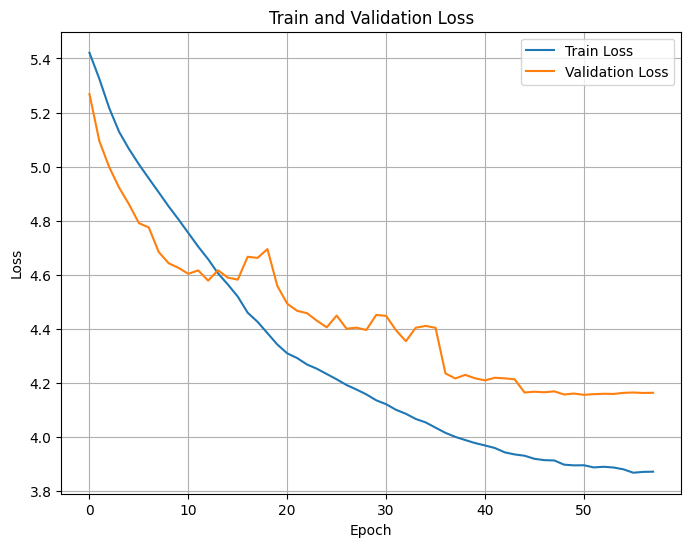

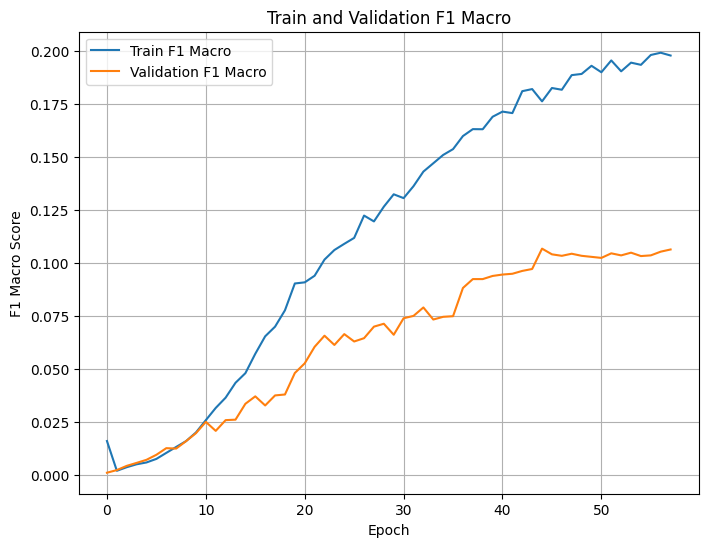

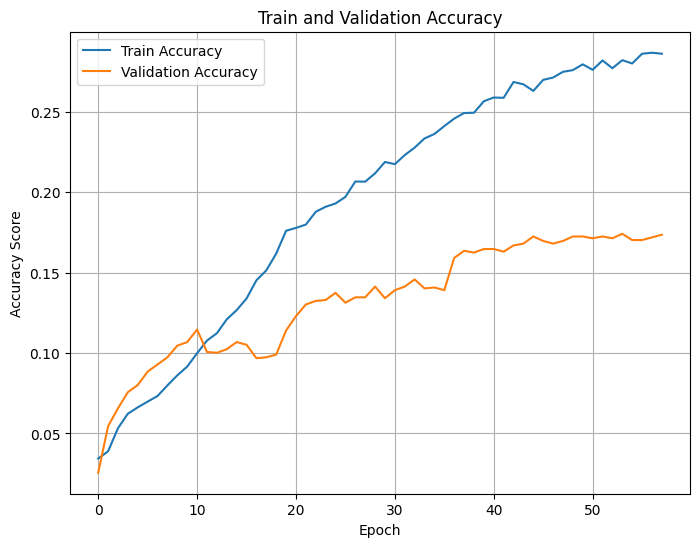

In [ ]:
# Chart 1: Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Chart 2: F1 Macro
plt.figure(figsize=(8, 6))
plt.plot(history.history['f1_macro'], label='Train F1 Macro')
plt.plot(history.history['val_f1_macro'], label='Validation F1 Macro')
plt.title('Train and Validation F1 Macro')
plt.xlabel('Epoch')
plt.ylabel('F1 Macro Score')
plt.legend()
plt.grid(True)
plt.show()

# Chart 3: Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
second_best_hp = tuner.get_best_hyperparameters(2)[1]

model = build_googlenet_modified(
    input_shape=(224, 224, 3),
    num_classes=202,
    dropout_rate=second_best_hp.get('dropout_rate'),
    filters_init=second_best_hp.get('filters_init'),
    kernel_size=second_best_hp.get('kernel_size'),
    neurons_dense=second_best_hp.get('neurons_dense'),
    weight_decay=5e-4
)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_228 (Conv2D) │ (None, 112, 112,  │      2,400 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_228[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_52    │ (None, 56, 56,    │          0 │ activation_12[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_229 (Conv2D) │ (None, 56, 56,    │      1,024 │ max_pooling2d_52… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        128 │ conv2d_229[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_230 (Conv2D) │ (None, 56, 56,    │     27,648 │ activation_13[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        384 │ conv2d_230[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_53    │ (None, 28, 28,    │          0 │ activation_14[0]… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_232 (Conv2D) │ (None, 28, 28,    │      3,104 │ max_pooling2d_53… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_234 (Conv2D) │ (None, 28, 28, 8) │        776 │ max_pooling2d_53… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_54    │ (None, 28, 28,    │          0 │ max_pooling2d_53… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_231 (Conv2D) │ (None, 28, 28,    │      3,104 │ max_pooling2d_53… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_233 (Conv2D) │ (None, 28, 28,    │     18,496 │ conv2d_232[0][0]  │
│                     │ 64)               │            │                 

 Total params: 1,493,438 (5.70 MB)

 Trainable params: 1,493,118 (5.70 MB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=second_best_hp.get("learning_rate")),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=second_best_hp.get("label_smoothing")),
        metrics=metrics
    )

# Run experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"googlenet_second_best_model",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(callbacks=callbacks, epochs=200)

preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

print("Best Epoch:", np.argmin(history.history["val_loss"]))

metrics_dict = {"Metric": [
        "Train Loss", "Val Loss",
        "Train Accuracy", "Val Accuracy",
        "Train F1 Macro", "Val F1 Macro",
        "Train F1 Weighted", "Val F1 Weighted",
        "Val Precision", "Val Recall"],
    "Score": [
        train_metrics["loss"], val_metrics["loss"],
        train_metrics["accuracy"], val_metrics["accuracy"],
        train_metrics["f1_macro"], val_metrics["f1_macro"],
        train_metrics["f1_weighted"], val_metrics["f1_weighted"],
        precision_score(y_true, y_pred, average='weighted'),
        recall_score(y_true, y_pred, average='weighted')]}

metrics_table = pd.DataFrame(metrics_dict)
print(metrics_table)

No checkpoint found, starting from scratch.
Epoch 1/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 57s 77ms/step - accuracy: 0.0624 - auc: 0.6108 - f1_macro: 0.0493 - f1_weighted: 0.0651 - loss: 5.4108 - top5_accuracy: 0.1489 - val_accuracy: 0.0239 - val_auc: 0.6078 - val_f1_macro: 2.3138e-04 - val_f1_weighted: 0.0011 - val_loss: 5.2723 - val_top5_accuracy: 0.1196 - learning_rate: 1.0000e-04
Epoch 2/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0264 - auc: 0.5828 - f1_macro: 0.0015 - f1_weighted: 0.0052 - loss: 5.3204 - top5_accuracy: 0.1012 - val_accuracy: 0.0562 - val_auc: 0.6662 - val_f1_macro: 0.0019 - val_f1_weighted: 0.0088 - val_loss: 5.1037 - val_top5_accuracy: 0.1642 - learning_rate: 1.0000e-04
Epoch 3/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.0411 - auc: 0.5982 - f1_macro: 0.0018 - f1_weighted: 0.0066 - loss: 5.2493 - top5_accuracy: 0.1260 - val_accuracy: 0.0668 - val_auc: 0.6771 - val_f1_macro: 0.0056 - val_f1_weighted: 0.0203 - val_loss: 5.0059 - val_top

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


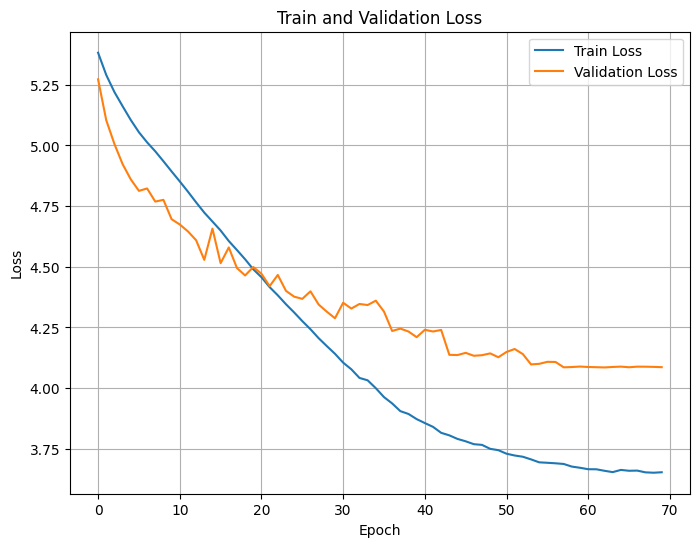

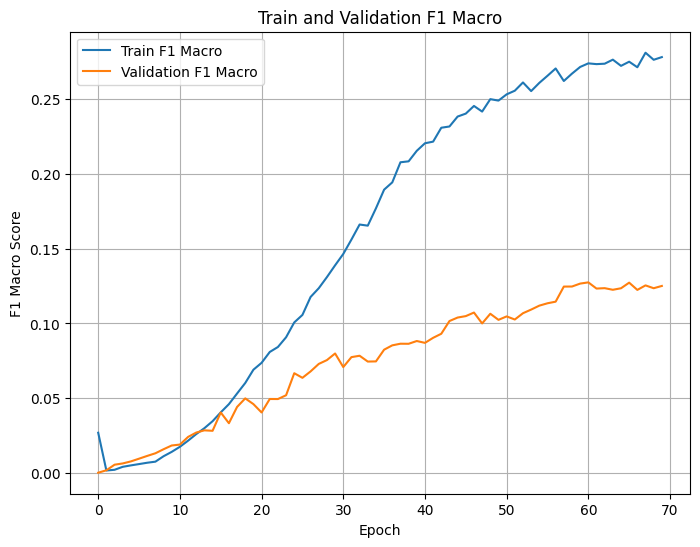

In [ ]:
# Chart 1: Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Chart 2: F1 Macro
plt.figure(figsize=(8, 6))
plt.plot(history.history['f1_macro'], label='Train F1 Macro')
plt.plot(history.history['val_f1_macro'], label='Validation F1 Macro')
plt.title('Train and Validation F1 Macro')
plt.xlabel('Epoch')
plt.ylabel('F1 Macro Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
third_best_hp = tuner.get_best_hyperparameters(3)[2]

model = build_googlenet_modified(
    input_shape=(224, 224, 3),
    num_classes=202,
    dropout_rate=third_best_hp.get('dropout_rate'),
    filters_init=third_best_hp.get('filters_init'),
    kernel_size=third_best_hp.get('kernel_size'),
    neurons_dense=third_best_hp.get('neurons_dense'),
    weight_decay=5e-4
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 112, 112,  │      4,800 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_285[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_65    │ (None, 56, 56,    │          0 │ activation_15[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 56, 56,    │      4,096 │ max_pooling2d_65… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_286[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_287 (Conv2D) │ (None, 56, 56,    │    110,592 │ activation_16[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        768 │ conv2d_287[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_66    │ (None, 28, 28,    │          0 │ activation_17[0]… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_289 (Conv2D) │ (None, 28, 28,    │     12,352 │ max_pooling2d_66… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_291 (Conv2D) │ (None, 28, 28,    │      3,088 │ max_pooling2d_66… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_67    │ (None, 28, 28,    │          0 │ max_pooling2d_66… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_288 (Conv2D) │ (None, 28, 28,    │     12,352 │ max_pooling2d_66… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_290 (Conv2D) │ (None, 28, 28,    │     73,856 │ conv2d_289[0][0]

 Total params: 5,756,980 (21.96 MB)

 Trainable params: 5,756,340 (21.96 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=third_best_hp.get("learning_rate")),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=third_best_hp.get("label_smoothing")),
        metrics=metrics
    )

# Run experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"googlenet_third_best_model",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(callbacks=callbacks, epochs=200)

preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

print("Best Epoch:", np.argmin(history.history["val_loss"]))

metrics_dict = {"Metric": [
        "Train Loss", "Val Loss",
        "Train Accuracy", "Val Accuracy",
        "Train F1 Macro", "Val F1 Macro",
        "Train F1 Weighted", "Val F1 Weighted",
        "Val Precision", "Val Recall"],
    "Score": [
        train_metrics["loss"], val_metrics["loss"],
        train_metrics["accuracy"], val_metrics["accuracy"],
        train_metrics["f1_macro"], val_metrics["f1_macro"],
        train_metrics["f1_weighted"], val_metrics["f1_weighted"],
        precision_score(y_true, y_pred, average='weighted'),
        recall_score(y_true, y_pred, average='weighted')]}

metrics_table = pd.DataFrame(metrics_dict)
print(metrics_table)

No checkpoint found, starting from scratch.
Epoch 1/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 89s 143ms/step - accuracy: 0.0745 - auc: 0.6232 - f1_macro: 0.0542 - f1_weighted: 0.0716 - loss: 5.4324 - top5_accuracy: 0.1699 - val_accuracy: 0.0234 - val_auc: 0.6155 - val_f1_macro: 5.2261e-04 - val_f1_weighted: 0.0025 - val_loss: 5.2836 - val_top5_accuracy: 0.1130 - learning_rate: 1.0000e-04
Epoch 2/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 113ms/step - accuracy: 0.0352 - auc: 0.5847 - f1_macro: 0.0013 - f1_weighted: 0.0047 - loss: 5.3233 - top5_accuracy: 0.1121 - val_accuracy: 0.0601 - val_auc: 0.6633 - val_f1_macro: 0.0027 - val_f1_weighted: 0.0130 - val_loss: 5.1339 - val_top5_accuracy: 0.1586 - learning_rate: 1.0000e-04
Epoch 3/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.0485 - auc: 0.6058 - f1_macro: 0.0021 - f1_weighted: 0.0072 - loss: 5.2360 - top5_accuracy: 0.1316 - val_accuracy: 0.0629 - val_auc: 0.6886 - val_f1_macro: 0.0031 - val_f1_weighted: 0.0141 - val_loss: 5.0047 - val_

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


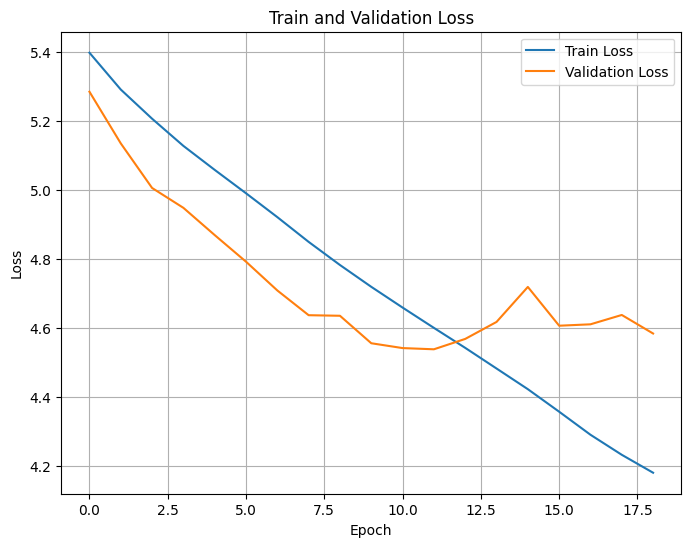

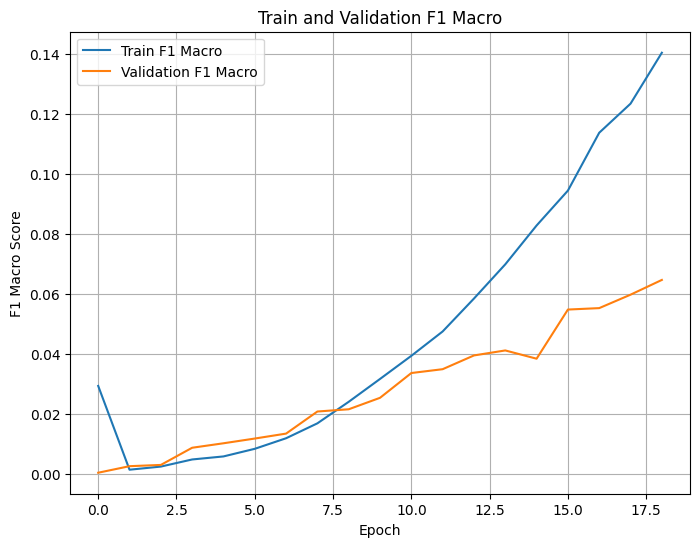

In [ ]:
# Chart 1: Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Chart 2: F1 Macro
plt.figure(figsize=(8, 6))
plt.plot(history.history['f1_macro'], label='Train F1 Macro')
plt.plot(history.history['val_f1_macro'], label='Validation F1 Macro')
plt.title('Train and Validation F1 Macro')
plt.xlabel('Epoch')
plt.ylabel('F1 Macro Score')
plt.legend()
plt.grid(True)
plt.show()

## 4.4 ResNet

### 4.4.1 Testing augmentations

In [ ]:
# Define your architectures (you already have build_resnet18)
model_builders = {
    "resnet18": build_resnet18
}

# Initialize preprocessor
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Store all results
all_results = []

# Loop over architectures and augmentations
for arch_name, build_fn in model_builders.items():
    for aug in augmentations_to_test:
        print(f"\nTraining architecture: {arch_name} with augmentation: {aug}")

        # Build model
        model = build_fn()

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
            metrics=metrics
        )

        # Load datasets
        train_ds, class_names = preprocess.load_img(
            data_dir=os.path.join(base_path, "data/rare_species/train"),
            minority_class=minority_class,
            augment=aug,
            oversampling=True,
            shuffle=True
        )

        if aug == "grayscale_plus":
            val_ds, _ = preprocess.load_img(
                data_dir=os.path.join(base_path, "data/rare_species/val"),
                minority_class=minority_class,
                augment=aug,
                oversampling=False
            )
        else:
            val_ds, _ = preprocess.load_img(
                data_dir=os.path.join(base_path, "data/rare_species/val"),
                minority_class=minority_class,
                augment=None,
                oversampling=False
            )

        # Initialize experiment
        experiment = Experiment(
            model=model,
            train_ds=train_ds,
            val_ds=val_ds,
            experiment_name=f"{arch_name}_with_{aug}",
            batch_size=batch_size,
            image_size=image_size,
            save_model=False
        )

        # Run training
        history = experiment.run_experiment(callbacks=callbacks, epochs=30)

        # Predict on validation set
        preds = model.predict(val_ds)
        y_pred = np.argmax(preds, axis=1)
        y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

        # Compute custom metrics
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')

        # Evaluate model using Keras metrics
        train_eval = model.evaluate(train_ds, verbose=0)
        val_eval = model.evaluate(val_ds, verbose=0)

        metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]
        train_metrics = dict(zip(metric_names, train_eval))
        val_metrics = dict(zip(metric_names, val_eval))

        # Append results
        all_results.append({
            "architecture": arch_name,
            "augmentation": aug,

            "train_loss": train_metrics["loss"],
            "val_loss": val_metrics["loss"],

            "train_accuracy": train_metrics["accuracy"],
            "val_accuracy": val_metrics["accuracy"],

            "val_f1_macro": f1_macro,
            "val_f1_weighted": f1_weighted,
            "val_precision": precision,
            "val_recall": recall
        })

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
display(results_df.round(4))



Training architecture: resnet18 with augmentation: none
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 61s 93ms/step - accuracy: 0.0335 - auc: 0.5781 - f1_macro: 0.0163 - f1_weighted: 0.0293 - loss: 6.1780 - top5_accuracy: 0.0885 - val_accuracy: 0.0312 - val_auc: 0.5803 - val_f1_macro: 0.0012 - val_f1_weighted: 0.0043 - val_loss: 5.6752 - val_top5_accuracy: 0.0979 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0426 - auc: 0.6136 - f1_macro: 0.0104 - f1_weighted: 0.0218 - loss: 5.6978 - top5_accuracy: 0.1056 - val_accuracy: 0.0440 - val_auc: 0.6510 - val_f1_macro: 0.0074 - val_f1_weighted: 0.0223 - val_loss: 5.6422 - val_top5_accuracy: 0.1436 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0546 - auc: 0.6510 - f1_macro: 0.0154 - f1_weighted: 0.0281 - loss: 5.5003 - top5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: medium
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 80s 148ms/step - accuracy: 0.0719 - auc: 0.6209 - f1_macro: 0.0475 - f1_weighted: 0.0715 - loss: 6.1404 - top5_accuracy: 0.1438 - val_accuracy: 0.0306 - val_auc: 0.5644 - val_f1_macro: 0.0021 - val_f1_weighted: 0.0090 - val_loss: 5.7797 - val_top5_accuracy: 0.0785 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0470 - auc: 0.6115 - f1_macro: 0.0105 - f1_weighted: 0.0247 - loss: 5.6764 - top5_accuracy: 0.1100 - val_accuracy: 0.0762 - val_auc: 0.6831 - val_f1_macro: 0.0079 - val_f1_weighted: 0.0302 - val_loss: 5.3587 - val_top5_accuracy: 0.1925 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0570 - auc: 0.6468 - f1_macro: 0.0132 - f1_weighted: 0.0280 - loss: 5.5027 - t

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: light
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 76s 137ms/step - accuracy: 0.0518 - auc: 0.6205 - f1_macro: 0.0187 - f1_weighted: 0.0398 - loss: 6.1808 - top5_accuracy: 0.1308 - val_accuracy: 0.0323 - val_auc: 0.5985 - val_f1_macro: 0.0014 - val_f1_weighted: 0.0058 - val_loss: 5.6504 - val_top5_accuracy: 0.0896 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0443 - auc: 0.6074 - f1_macro: 0.0120 - f1_weighted: 0.0258 - loss: 5.7234 - top5_accuracy: 0.1073 - val_accuracy: 0.0746 - val_auc: 0.6674 - val_f1_macro: 0.0104 - val_f1_weighted: 0.0339 - val_loss: 6.4401 - val_top5_accuracy: 0.1881 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.0591 - auc: 0.6461 - f1_macro: 0.0161 - f1_weighted: 0.0328 - loss: 5.5337 - to

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: mixup
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 62s 94ms/step - accuracy: 0.0194 - auc: 0.5402 - f1_macro: 0.0052 - f1_weighted: 0.0107 - loss: 6.1584 - top5_accuracy: 0.0589 - val_accuracy: 0.0378 - val_auc: 0.5853 - val_f1_macro: 0.0030 - val_f1_weighted: 0.0128 - val_loss: 5.6308 - val_top5_accuracy: 0.0991 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0388 - auc: 0.5770 - f1_macro: 0.0083 - f1_weighted: 0.0182 - loss: 5.7615 - top5_accuracy: 0.1034 - val_accuracy: 0.0690 - val_auc: 0.7012 - val_f1_macro: 0.0063 - val_f1_weighted: 0.0242 - val_loss: 5.3662 - val_top5_accuracy: 0.1970 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0499 - auc: 0.6012 - f1_macro: 0.0089 - f1_weighted: 0.0210 - loss: 5.6112 - top

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: heavy
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.0627 - auc: 0.6228 - f1_macro: 0.0355 - f1_weighted: 0.0544 - loss: 6.1103 - top5_accuracy: 0.1362 - val_accuracy: 0.0317 - val_auc: 0.5715 - val_f1_macro: 0.0016 - val_f1_weighted: 0.0069 - val_loss: 5.6822 - val_top5_accuracy: 0.1046 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0379 - auc: 0.6066 - f1_macro: 0.0083 - f1_weighted: 0.0195 - loss: 5.7166 - top5_accuracy: 0.1031 - val_accuracy: 0.0618 - val_auc: 0.6917 - val_f1_macro: 0.0062 - val_f1_weighted: 0.0250 - val_loss: 5.3997 - val_top5_accuracy: 0.1820 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0455 - auc: 0.6312 - f1_macro: 0.0100 - f1_weighted: 0.0217 - loss: 5.5709 - to

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: grayscale_plus
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 77s 139ms/step - accuracy: 0.0560 - auc: 0.6269 - f1_macro: 0.0271 - f1_weighted: 0.0458 - loss: 6.1472 - top5_accuracy: 0.1387 - val_accuracy: 0.0250 - val_auc: 0.5722 - val_f1_macro: 0.0012 - val_f1_weighted: 0.0058 - val_loss: 5.8031 - val_top5_accuracy: 0.0924 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0319 - auc: 0.5936 - f1_macro: 0.0070 - f1_weighted: 0.0157 - loss: 5.7600 - top5_accuracy: 0.0881 - val_accuracy: 0.0618 - val_auc: 0.6772 - val_f1_macro: 0.0050 - val_f1_weighted: 0.0196 - val_loss: 5.4015 - val_top5_accuracy: 0.1558 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0410 - auc: 0.6216 - f1_macro: 0.0095 - f1_weighted: 0.0201 - loss: 5.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: randaugment
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 76s 131ms/step - accuracy: 0.0444 - auc: 0.6019 - f1_macro: 0.0199 - f1_weighted: 0.0377 - loss: 6.2042 - top5_accuracy: 0.1070 - val_accuracy: 0.0211 - val_auc: 0.5864 - val_f1_macro: 3.0077e-04 - val_f1_weighted: 0.0014 - val_loss: 5.6555 - val_top5_accuracy: 0.0979 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0242 - auc: 0.5692 - f1_macro: 0.0048 - f1_weighted: 0.0118 - loss: 5.9009 - top5_accuracy: 0.0719 - val_accuracy: 0.0707 - val_auc: 0.6605 - val_f1_macro: 0.0051 - val_f1_weighted: 0.0190 - val_loss: 5.4383 - val_top5_accuracy: 0.1614 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0280 - auc: 0.5966 - f1_macro: 0.0056 - f1_weighted: 0.0129 - loss: 5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: color_lightening
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 62s 98ms/step - accuracy: 0.0629 - auc: 0.6237 - f1_macro: 0.0349 - f1_weighted: 0.0540 - loss: 6.1451 - top5_accuracy: 0.1407 - val_accuracy: 0.0362 - val_auc: 0.5980 - val_f1_macro: 0.0019 - val_f1_weighted: 0.0054 - val_loss: 5.6412 - val_top5_accuracy: 0.0996 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0400 - auc: 0.6091 - f1_macro: 0.0101 - f1_weighted: 0.0218 - loss: 5.7033 - top5_accuracy: 0.1089 - val_accuracy: 0.0679 - val_auc: 0.6981 - val_f1_macro: 0.0074 - val_f1_weighted: 0.0293 - val_loss: 5.3655 - val_top5_accuracy: 0.1970 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0551 - auc: 0.6448 - f1_macro: 0.0127 - f1_weighted: 0.0273 - loss: 5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet18 with augmentation: geometric_transformations
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 79s 144ms/step - accuracy: 0.0631 - auc: 0.6215 - f1_macro: 0.0321 - f1_weighted: 0.0577 - loss: 6.1852 - top5_accuracy: 0.1346 - val_accuracy: 0.0289 - val_auc: 0.5773 - val_f1_macro: 0.0019 - val_f1_weighted: 0.0075 - val_loss: 5.7486 - val_top5_accuracy: 0.0918 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.0355 - auc: 0.5939 - f1_macro: 0.0093 - f1_weighted: 0.0199 - loss: 5.7652 - top5_accuracy: 0.0886 - val_accuracy: 0.0696 - val_auc: 0.6682 - val_f1_macro: 0.0074 - val_f1_weighted: 0.0258 - val_loss: 5.6301 - val_top5_accuracy: 0.1781 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.0499 - auc: 0.6349 - f1_macro: 0.0114 - f1_weighted: 0.0243

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,architecture,augmentation,train_loss,val_loss,train_accuracy,val_accuracy,val_f1_macro,val_f1_weighted,val_precision,val_recall
0,resnet18,none,1.3911,4.5692,0.9362,0.1920,0.1255,0.1746,0.1920,0.1920
1,resnet18,medium,4.5955,4.7878,0.1363,0.1319,0.0420,0.0865,0.1112,0.1319
2,resnet18,light,5.7216,5.6504,0.0232,0.0323,0.0014,0.0058,0.0046,0.0323
3,resnet18,mixup,3.7449,4.7442,0.4610,0.1642,0.0930,0.1301,0.1555,0.1642
4,resnet18,heavy,3.6324,4.5743,0.2922,0.1469,0.0638,0.1057,0.0993,0.1469
5,resnet18,grayscale_plus,2.9042,4.9170,0.5308,0.1230,0.0487,0.0880,0.0835,0.1230
6,resnet18,randaugment,3.4322,4.5227,0.3413,0.1697,0.0846,0.1234,0.1138,0.1697
7,resnet18,color_lightening,3.3282,4.6069,0.3733,0.1720,0.0789,0.1344,0.1446,0.1720
8,resnet18,geometric_transformations,4.0121,4.5991,0.2145,0.1586,0.0755,0.1224,0.1463,0.1586


In [ ]:
# Sort by f1_macro descending
results_df = results_df.sort_values(by="val_f1_macro", ascending=False).reset_index(drop=True)

# Display the table
display(results_df.round(4))

,architecture,augmentation,train_loss,val_loss,train_accuracy,val_accuracy,val_f1_macro,val_f1_weighted,val_precision,val_recall
0,resnet18,none,1.3911,4.5692,0.9362,0.1920,0.1255,0.1746,0.1920,0.1920
1,resnet18,mixup,3.7449,4.7442,0.4610,0.1642,0.0930,0.1301,0.1555,0.1642
2,resnet18,randaugment,3.4322,4.5227,0.3413,0.1697,0.0846,0.1234,0.1138,0.1697
3,resnet18,color_lightening,3.3282,4.6069,0.3733,0.1720,0.0789,0.1344,0.1446,0.1720
4,resnet18,geometric_transformations,4.0121,4.5991,0.2145,0.1586,0.0755,0.1224,0.1463,0.1586
5,resnet18,heavy,3.6324,4.5743,0.2922,0.1469,0.0638,0.1057,0.0993,0.1469
6,resnet18,grayscale_plus,2.9042,4.9170,0.5308,0.1230,0.0487,0.0880,0.0835,0.1230
7,resnet18,medium,4.5955,4.7878,0.1363,0.1319,0.0420,0.0865,0.1112,0.1319
8,resnet18,light,5.7216,5.6504,0.0232,0.0323,0.0014,0.0058,0.0046,0.0323


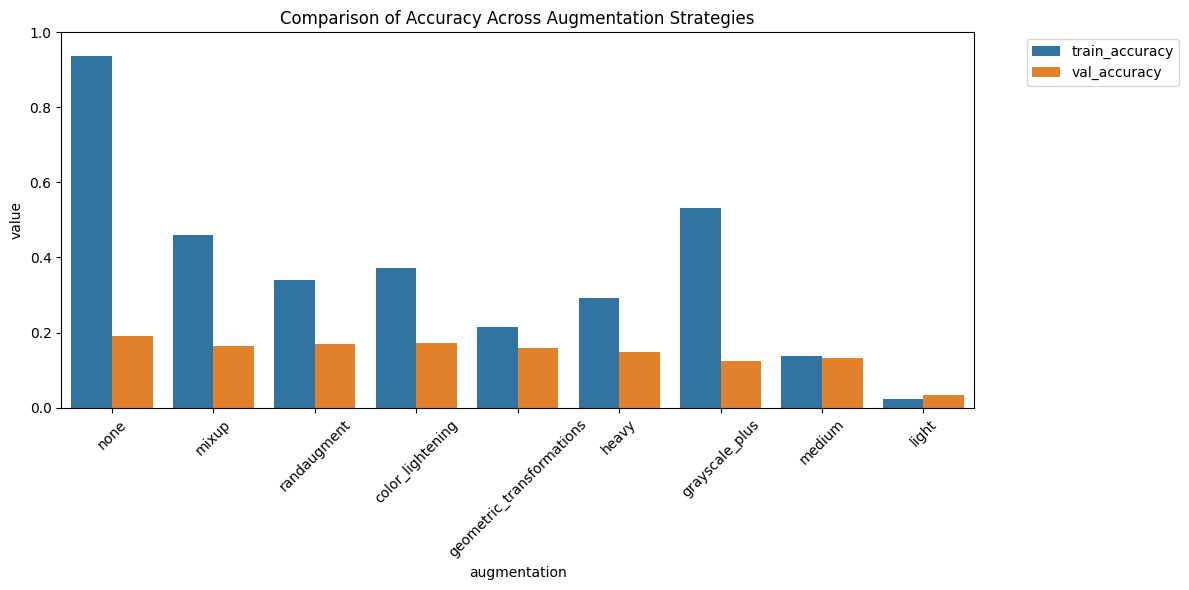

In [ ]:
# Melt the DataFrame for seaborn plotting
metrics_to_plot = ['train_accuracy', 'val_accuracy']
melted_df = results_df.melt(id_vars='augmentation', value_vars=metrics_to_plot,
                            var_name='metric', value_name='value')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='augmentation', y='value', hue='metric')
plt.title("Comparison of Accuracy Across Augmentation Strategies")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 4.4.2 Testing default architectures

In [ ]:
# Pre processing
batch_size = 32
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

# Define models to test
model_builders = {
    "resnet18": build_resnet18,
    "resnet50": build_resnet50}

# # Store all results
# all_results = []


# Loop over architectures and augmentations
for arch_name, build_fn in model_builders.items():
  print(f"\nTraining architecture: {arch_name}")
  model = build_fn()
  model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
            metrics=metrics
        )

  # Load datasets
  train_ds, class_names = preprocess.load_img(
      data_dir=os.path.join(base_path, "data/rare_species/train"),
      minority_class=minority_class,
      augment="mixup",
      oversampling=True,
      shuffle=True
  )


  val_ds, _ = preprocess.load_img(
      data_dir=os.path.join(base_path, "data/rare_species/val"),
      minority_class=minority_class,
      augment=None,
      oversampling=False
  )

  # Run experiment
  model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=30,
            callbacks=callbacks
)

  # Predict on validation set
  preds = model.predict(val_ds)
  y_pred = np.argmax(preds, axis=1)
  y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

  # Compute custom metrics
  f1_macro = f1_score(y_true, y_pred, average='macro')
  f1_weighted = f1_score(y_true, y_pred, average='weighted')
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')

  # Evaluate model using Keras metrics
  train_eval = model.evaluate(train_ds, verbose=0)
  val_eval = model.evaluate(val_ds, verbose=0)

  metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]
  train_metrics = dict(zip(metric_names, train_eval))
  val_metrics = dict(zip(metric_names, val_eval))

  # Append results
  all_results.append({
      "architecture": arch_name,
      "train_loss": train_metrics["loss"],
      "val_loss": val_metrics["loss"],

      "train_accuracy": train_metrics["accuracy"],
      "val_accuracy": val_metrics["accuracy"],

      "train_f1_macro": train_metrics["f1_macro"],
      "val_f1_macro": f1_macro,
      "val_f1_weighted": f1_weighted,
      "val_precision": precision,
      "val_recall": recall
  })

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(by="val_f1_macro", ascending=False).reset_index(drop=True)
display(results_df.round(4))



Training architecture: resnet18
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 79s 154ms/step - accuracy: 0.0404 - auc: 0.5840 - f1_macro: 0.0087 - f1_weighted: 0.0190 - loss: 6.0735 - top5_accuracy: 0.1075 - val_accuracy: 0.0473 - val_auc: 0.5703 - val_f1_macro: 0.0040 - val_f1_weighted: 0.0155 - val_loss: 5.6565 - val_top5_accuracy: 0.1046 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.0180 - auc: 0.5473 - f1_macro: 0.0054 - f1_weighted: 0.0116 - loss: 5.7964 - top5_accuracy: 0.0630 - val_accuracy: 0.0523 - val_auc: 0.6152 - val_f1_macro: 0.0030 - val_f1_weighted: 0.0137 - val_loss: 5.5965 - val_top5_accuracy: 0.1469 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - accuracy: 0.0278 - auc: 0.5675 - f1_macro: 0.0042 - f1_weighted: 0.0115 - loss: 5.7102 - top5_accuracy: 0.0837 - val_accuracy: 0.0735 - val_auc: 0.6477 - val_

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: resnet50
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 171s 336ms/step - accuracy: 0.0648 - auc: 0.6209 - f1_macro: 0.0183 - f1_weighted: 0.0333 - loss: 7.5056 - top5_accuracy: 0.1556 - val_accuracy: 0.0173 - val_auc: 0.5783 - val_f1_macro: 0.0016 - val_f1_weighted: 0.0060 - val_loss: 7.3374 - val_top5_accuracy: 0.0801 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 105s 299ms/step - accuracy: 0.0513 - auc: 0.6128 - f1_macro: 0.0069 - f1_weighted: 0.0175 - loss: 6.9644 - top5_accuracy: 0.1398 - val_accuracy: 0.0595 - val_auc: 0.6607 - val_f1_macro: 0.0126 - val_f1_weighted: 0.0330 - val_loss: 8.9673 - val_top5_accuracy: 0.1619 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 104s 297ms/step - accuracy: 0.0656 - auc: 0.6380 - f1_macro: 0.0138 - f1_weighted: 0.0261 - loss: 6.7894 - top5_accuracy: 0.1695 - val_accuracy: 0.0568 - val_auc: 0.6741 - v

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training architecture: wideresnet
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.0463 - auc: 0.5795 - f1_macro: 0.0261 - f1_weighted: 0.0385 - loss: 6.0822 - top5_accuracy: 0.1137 - val_accuracy: 0.0434 - val_auc: 0.6186 - val_f1_macro: 0.0036 - val_f1_weighted: 0.0138 - val_loss: 5.5238 - val_top5_accuracy: 0.1369 - learning_rate: 1.0000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 603s 2s/step - accuracy: 0.0317 - auc: 0.5733 - f1_macro: 0.0057 - f1_weighted: 0.0133 - loss: 5.7389 - top5_accuracy: 0.0940 - val_accuracy: 0.0673 - val_auc: 0.6843 - val_f1_macro: 0.0054 - val_f1_weighted: 0.0221 - val_loss: 5.4227 - val_top5_accuracy: 0.1875 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 602s 2s/step - accuracy: 0.0408 - auc: 0.5890 - f1_macro: 0.0068 - f1_weighted: 0.0160 - loss: 5.6118 - top5_accuracy: 0.1158 - val_accuracy: 0.0657 - val_auc: 0.7028 - val_f1_m

KeyboardInterrupt: 

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(by="val_f1_macro", ascending=False).reset_index(drop=True)
display(results_df.round(4))

,Model,Train Loss,Val Loss,Train Accuracy,Val Accuracy,Train F1 Macro,Val F1 Macro,Val F1 Weighted,Val Precision,Val Recall
0,resnet50,5.670595,7.146533,0.274643,0.117418,0.203310,0.069680,0.098150,0.120132,0.117418
1,resnet18,4.647948,4.554696,0.149196,0.145799,0.037152,0.037855,0.074594,0.070405,0.145799
2,resnet18,5.085986,4.878768,0.064286,0.081247,0.005007,0.007162,0.028198,0.022930,0.081247


### 4.4.3 Tuning

In [ ]:
# Model builder
def build_model_resnet18(hp):
#    learning_rate = hp.Choice("learning_rate", [1e-4, 5e-5])
    l2_weight = hp.Choice("l2_weight", [1e-5, 1e-4, 5e-4])
    head_units = hp.Choice("head_units", [128, 256, 512])
    head_activation = hp.Choice("head_activation", ["relu", "leaky_relu"])
    dropout_rate = hp.Choice("dropout_rate", [0.4, 0.5])

    num_blocks = [
        hp.Choice("blocks_stage1", [2, 3]),
        hp.Choice("blocks_stage2", [2, 3, 4]),
        hp.Choice("blocks_stage3", [2, 4, 6]),
        hp.Choice("blocks_stage4", [2, 3])
    ]

    model = build_resnet18(
        num_blocks=num_blocks,
        l2_weight=l2_weight,
        head_units=head_units,
        head_activation=head_activation,
        dropout_rate=dropout_rate
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
        metrics=metrics  # must include 'f1_macro' and 'val_f1_macro'
    )

    return model

In [ ]:
# Custom tuner with augmentation and overfit control
class MyAugTuner(Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        aug = "mixup"
        oversample = True

        train_ds, _ = preprocess.load_img(
            data_dir=os.path.join(base_path, "data/rare_species/train"),
            minority_class=minority_class,
            augment=aug,
            oversampling=oversample,
            shuffle=True
        )

        val_ds, _ = preprocess.load_img(
            data_dir=os.path.join(base_path, "data/rare_species/val"),
            minority_class=minority_class,
            augment=None,
            oversampling=False
        )

        model = build_model_resnet18(hp)
        epochs = trial.hyperparameters.get('tuner/epochs')

        return model.fit(
            train_ds,
            validation_data=val_ds,
            callbacks=callbacks,
            epochs=epochs,
            verbose=1
        )

In [ ]:
# Preprocessing
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

callbacks = callbacks + [OverfitStopper()]

# Tuner
tuner = MyAugTuner(
    hypermodel=build_model_resnet18,
    objective=Objective("val_f1_macro", direction="max"),
    max_epochs=20,
    factor=3,
    directory="tuner_dir",
    project_name="resnet18_mixup_control_overfit"
)

# Search
tuner.search(callbacks=callbacks)

Reloading Tuner from tuner_dir/resnet18_mixup_control_overfit/tuner0.json


In [ ]:
# Preprocessing
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

callbacks = callbacks + [OverfitStopper()]

# Tuner
tuner = MyAugTuner(
    hypermodel=build_model_resnet18,
    objective=Objective("val_f1_macro", direction="max"),
    max_epochs=20,
    factor=3,
    directory="tuner_dir",
    project_name="resnet18_mixup_control_overfit_varying_dropout"
)

# Search
tuner.search(callbacks=callbacks)

Reloading Tuner from tuner_dir/resnet18_mixup_control_overfit_varying_dropout/tuner0.json


In [ ]:
top_n = 10
top_hps = tuner.get_best_hyperparameters(top_n)

# Loop over all trials and match by hyperparameter values
for i, hp in enumerate(top_hps):
    matched_trial = None
    for trial in tuner.oracle.trials.values():
        if trial.hyperparameters.values == hp.values:
            matched_trial = trial
            break

    if matched_trial is None:
        print(f"\n No trial found for top {i+1}")
        continue

    print(f"\n Top {i+1} trial (Score: {matched_trial.score:.4f}):")

    print("  Num blocks per stage:", [
        hp.get("blocks_stage1"),
        hp.get("blocks_stage2"),
        hp.get("blocks_stage3"),
        hp.get("blocks_stage4"),
    ])
    print("  Head Activation:", hp.get("head_activation"))
    print("  Head Units:", hp.get("head_units"))
    print("  L2 weight:", hp.get("l2_weight"))
    print("  Learning rate:", hp.get("learning_rate"))



🔹 Top 1 trial (Score: 0.0714):
  Num blocks per stage: [3, 4, 2, 2]
  Head Activation: relu
  Head Units: 256
  L2 weight: 0.0005
  Learning rate: 0.0001

🔹 Top 2 trial (Score: 0.0688):
  Num blocks per stage: [3, 4, 2, 2]
  Head Activation: relu
  Head Units: 256
  L2 weight: 0.0005
  Learning rate: 0.0001

🔹 Top 3 trial (Score: 0.0651):
  Num blocks per stage: [3, 4, 2, 2]
  Head Activation: relu
  Head Units: 256
  L2 weight: 0.0005
  Learning rate: 0.0001

🔹 Top 4 trial (Score: 0.0623):
  Num blocks per stage: [3, 3, 6, 2]
  Head Activation: relu
  Head Units: 128
  L2 weight: 0.0001
  Learning rate: 0.0001

🔹 Top 5 trial (Score: 0.0618):
  Num blocks per stage: [3, 4, 6, 2]
  Head Activation: relu
  Head Units: 512
  L2 weight: 0.0005
  Learning rate: 5e-05

🔹 Top 6 trial (Score: 0.0584):
  Num blocks per stage: [2, 3, 4, 3]
  Head Activation: leaky_relu
  Head Units: 128
  L2 weight: 0.0001
  Learning rate: 0.0001

🔹 Top 7 trial (Score: 0.0582):
  Num blocks per stage: [2, 3, 2,

In [ ]:
top_n = 10
top_hps = tuner.get_best_hyperparameters(top_n)

# Loop over all trials and match by hyperparameter values
for i, hp in enumerate(top_hps):
    matched_trial = None
    for trial in tuner.oracle.trials.values():
        if trial.hyperparameters.values == hp.values:
            matched_trial = trial
            break

    if matched_trial is None:
        print(f"\n No trial found for top {i+1}")
        continue

    print(f"\n Top {i+1} trial (Score: {matched_trial.score:.4f}):")

    print("  Num blocks per stage:", [
        hp.get("blocks_stage1"),
        hp.get("blocks_stage2"),
        hp.get("blocks_stage3"),
        hp.get("blocks_stage4"),
    ])
    print("  Head Activation:", hp.get("head_activation"))
    print("  Head Units:", hp.get("head_units"))
    print("  L2 weight:", hp.get("l2_weight"))
    print("  Dropout:", hp.get("dropout_rate"))



🔹 Top 1 trial (Score: 0.0737):
  Num blocks per stage: [3, 3, 4, 3]
  Head Activation: leaky_relu
  Head Units: 512
  L2 weight: 1e-05
  Dropout: 0.4

🔹 Top 2 trial (Score: 0.0660):
  Num blocks per stage: [3, 3, 4, 2]
  Head Activation: relu
  Head Units: 512
  L2 weight: 0.0001
  Dropout: 0.4

🔹 Top 3 trial (Score: 0.0570):
  Num blocks per stage: [2, 4, 2, 3]
  Head Activation: relu
  Head Units: 512
  L2 weight: 0.0005
  Dropout: 0.4

🔹 Top 4 trial (Score: 0.0550):
  Num blocks per stage: [3, 4, 2, 3]
  Head Activation: relu
  Head Units: 512
  L2 weight: 0.0001
  Dropout: 0.4

🔹 Top 5 trial (Score: 0.0544):
  Num blocks per stage: [2, 4, 2, 3]
  Head Activation: leaky_relu
  Head Units: 256
  L2 weight: 0.0005
  Dropout: 0.5

🔹 Top 6 trial (Score: 0.0524):
  Num blocks per stage: [2, 3, 2, 2]
  Head Activation: leaky_relu
  Head Units: 128
  L2 weight: 0.0005
  Dropout: 0.4

🔹 Top 7 trial (Score: 0.0519):
  Num blocks per stage: [2, 2, 4, 2]
  Head Activation: relu
  Head Units: 

### 4.4.3 Deciding the best model

In [ ]:
# Add callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    , EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss", verbose=1)
]

In [ ]:
# Preprocessing
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

train_ds, _ = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/train"),
    minority_class=minority_class,
    augment="medium",
    oversampling=True,
    shuffle=True
)

val_ds, _ = preprocess.load_img(
    data_dir=os.path.join(base_path, "data/rare_species/val"),
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]

model = build_resnet18(
    input_shape=(224, 224, 3),
    num_classes=202,
    num_blocks=[
        best_hp.get("blocks_stage1"),
        best_hp.get("blocks_stage2"),
        best_hp.get("blocks_stage3"),
        best_hp.get("blocks_stage4"),
    ],
    l2_weight=best_hp.get("l2_weight"),
    dropout_rate=0.5,
    head_units=best_hp.get("head_units"),
    head_activation=best_hp.get("head_activation")
)
model = build_model_resnet18(hp)
model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_45      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_877 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_45[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_877[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_798 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 56, 56,    │          0 │ re_lu_798[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_878 (Conv2D) │ (None, 56, 56,    │     36,928 │ max_pooling2d_32… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_878[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_799 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_879 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_799[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_879[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_343 (Add)       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_32… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_800 (ReLU)    │ (None, 56, 56,    │          0 │ add_343[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_880 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_800[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_880[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_801 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_881 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_801[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_881[0][0]

 Total params: 11,855,434 (45.22 MB)

 Trainable params: 11,844,298 (45.18 MB)

 Non-trainable params: 11,136 (43.50 KB)

#### 1. Best - Cresce devagar mas não overfita

##### dropout 0.5

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_hp.get("learning_rate")),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
        metrics=metrics
    )


# Run experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"resnet18_mixup_best_model",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(callbacks=callbacks, epochs=40)

preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

print("Best Epoch:", np.argmin(history.history["val_loss"]))

print("Train Loss:", train_metrics["loss"])
print("Val Loss:", val_metrics["loss"])
print("Train Accuracy:", train_metrics["accuracy"])
print("Val Accuracy:", val_metrics["accuracy"])
print("Train F1 Macro:", train_metrics["f1_macro"])
print("Val F1 Macro:", val_metrics["f1_macro"])
print("Train F1 Weighted:", train_metrics["f1_weighted"])
print("Val F1 Weighted:", val_metrics["f1_weighted"])

print("Val Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Val Recall:", recall_score(y_true, y_pred, average='weighted'))


No checkpoint found, starting from scratch.
Epoch 1/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - accuracy: 0.0579 - auc: 0.6168 - f1_macro: 0.0227 - f1_weighted: 0.0460 - loss: 6.4523 - top5_accuracy: 0.1371 - val_accuracy: 0.0323 - val_auc: 0.6152 - val_f1_macro: 0.0016 - val_f1_weighted: 0.0067 - val_loss: 5.6276 - val_top5_accuracy: 0.1196 - learning_rate: 1.0000e-04
Epoch 2/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0260 - auc: 0.5793 - f1_macro: 0.0059 - f1_weighted: 0.0139 - loss: 6.0515 - top5_accuracy: 0.0761 - val_accuracy: 0.0607 - val_auc: 0.6487 - val_f1_macro: 0.0068 - val_f1_weighted: 0.0220 - val_loss: 5.7317 - val_top5_accuracy: 0.1514 - learning_rate: 1.0000e-04
Epoch 3/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0328 - auc: 0.5999 - f1_macro: 0.0075 - f1_weighted: 0.0172 - loss: 5.8999 - top5_accuracy: 0.1003 - val_accuracy: 0.0684 - val_auc: 0.6693 - val_f1_macro: 0.0075 - val_f1_weighted: 0.0240 - val_loss: 5.5166 - val_top5_accur

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### dropout 0.4

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_hp.get("learning_rate")),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
        metrics=metrics
    )


# Run experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"resnet18_mixup_best_model",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(callbacks=callbacks, epochs=40)

preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

print("Best Epoch:", np.argmin(history.history["val_loss"]))

print("Train Loss:", train_metrics["loss"])
print("Val Loss:", val_metrics["loss"])
print("Train Accuracy:", train_metrics["accuracy"])
print("Val Accuracy:", val_metrics["accuracy"])
print("Train F1 Macro:", train_metrics["f1_macro"])
print("Val F1 Macro:", val_metrics["f1_macro"])
print("Train F1 Weighted:", train_metrics["f1_weighted"])
print("Val F1 Weighted:", val_metrics["f1_weighted"])

print("Val Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Val Recall:", recall_score(y_true, y_pred, average='weighted'))


No checkpoint found, starting from scratch.
Epoch 1/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - accuracy: 0.0491 - auc: 0.6191 - f1_macro: 0.0233 - f1_weighted: 0.0405 - loss: 6.3963 - top5_accuracy: 0.1228 - val_accuracy: 0.0295 - val_auc: 0.6055 - val_f1_macro: 0.0014 - val_f1_weighted: 0.0044 - val_loss: 5.6360 - val_top5_accuracy: 0.1152 - learning_rate: 1.0000e-04
Epoch 2/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.0309 - auc: 0.5794 - f1_macro: 0.0074 - f1_weighted: 0.0168 - loss: 6.0196 - top5_accuracy: 0.0866 - val_accuracy: 0.0785 - val_auc: 0.6870 - val_f1_macro: 0.0064 - val_f1_weighted: 0.0247 - val_loss: 5.4611 - val_top5_accuracy: 0.1848 - learning_rate: 1.0000e-04
Epoch 3/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0355 - auc: 0.6006 - f1_macro: 0.0053 - f1_weighted: 0.0152 - loss: 5.8924 - top5_accuracy: 0.1057 - val_accuracy: 0.0751 - val_auc: 0.6964 - val_f1_macro: 0.0079 - val_f1_weighted: 0.0269 - val_loss: 5.4181 - val_top5_accur

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### dropout=0.5, learning rate = 1e-3

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
        metrics=metrics
    )


# Run experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"resnet18_mixup_best_model",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(callbacks=callbacks, epochs=70)

preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

print("Best Epoch:", np.argmin(history.history["val_loss"]))

print("Train Loss:", train_metrics["loss"])
print("Val Loss:", val_metrics["loss"])
print("Train Accuracy:", train_metrics["accuracy"])
print("Val Accuracy:", val_metrics["accuracy"])
print("Train F1 Macro:", train_metrics["f1_macro"])
print("Val F1 Macro:", val_metrics["f1_macro"])
print("Train F1 Weighted:", train_metrics["f1_weighted"])
print("Val F1 Weighted:", val_metrics["f1_weighted"])

print("Val Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Val Recall:", recall_score(y_true, y_pred, average='weighted'))

No checkpoint found, starting from scratch.
Epoch 1/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 59s 78ms/step - accuracy: 0.0576 - auc: 0.6359 - f1_macro: 0.0235 - f1_weighted: 0.0391 - loss: 6.3237 - top5_accuracy: 0.1487 - val_accuracy: 0.0378 - val_auc: 0.6246 - val_f1_macro: 0.0017 - val_f1_weighted: 0.0077 - val_loss: 6.5658 - val_top5_accuracy: 0.1391 - learning_rate: 0.0010
Epoch 2/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.0324 - auc: 0.5983 - f1_macro: 0.0043 - f1_weighted: 0.0109 - loss: 5.7774 - top5_accuracy: 0.1062 - val_accuracy: 0.0390 - val_auc: 0.6377 - val_f1_macro: 0.0023 - val_f1_weighted: 0.0096 - val_loss: 6.0535 - val_top5_accuracy: 0.1308 - learning_rate: 0.0010
Epoch 3/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0387 - auc: 0.6222 - f1_macro: 0.0042 - f1_weighted: 0.0123 - loss: 5.5400 - top5_accuracy: 0.1186 - val_accuracy: 0.0612 - val_auc: 0.6523 - val_f1_macro: 0.0050 - val_f1_weighted: 0.0192 - val_loss: 5.2866 - val_top5_accuracy: 0.1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
second_best_hp = tuner.get_best_hyperparameters(4)[0]
second_best_hp

model = build_resnet18(
    input_shape=(224, 224, 3),
    num_classes=202,
    num_blocks=[
        second_best_hp.get("blocks_stage1"),
        second_best_hp.get("blocks_stage2"),
        second_best_hp.get("blocks_stage3"),
        second_best_hp.get("blocks_stage4"),
    ],
    dropout_rate=0.5,
    l2_weight=second_best_hp.get("l2_weight"),
    head_units=second_best_hp.get("head_units"),
    head_activation=second_best_hp.get("head_activation")
)
model = build_model_resnet18(hp)
model.summary()

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_49      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_973 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_49[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_973[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_886 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_36    │ (None, 56, 56,    │          0 │ re_lu_886[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_974 (Conv2D) │ (None, 56, 56,    │     36,928 │ max_pooling2d_36… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_974[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_887 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_975 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_887[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_975[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_383 (Add)       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_36… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_888 (ReLU)    │ (None, 56, 56,    │          0 │ add_383[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_976 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_888[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_976[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_889 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_977 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_889[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_977[0][0]

 Total params: 11,855,434 (45.22 MB)

 Trainable params: 11,844,298 (45.18 MB)

 Non-trainable params: 11,136 (43.50 KB)

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
        metrics=metrics
    )


# Run experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"resnet18_mixup_best_model",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(callbacks=callbacks, epochs=40)

preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

print("Best Epoch:", np.argmin(history.history["val_loss"]))
print("Train Loss:", train_metrics["loss"])
print("Val Loss:", val_metrics["loss"])
print("Train Accuracy:", train_metrics["accuracy"])
print("Val Accuracy:", val_metrics["accuracy"])
print("Train F1 Macro:", train_metrics["f1_macro"])
print("Val F1 Macro:", val_metrics["f1_macro"])
print("Train F1 Weighted:", train_metrics["f1_weighted"])
print("Val F1 Weighted:", val_metrics["f1_weighted"])

print("Val Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Val Recall:", recall_score(y_true, y_pred, average='weighted'))


No checkpoint found, starting from scratch.
Epoch 1/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 77ms/step - accuracy: 0.0315 - auc: 0.6118 - f1_macro: 0.0044 - f1_weighted: 0.0115 - loss: 6.4016 - top5_accuracy: 0.1066 - val_accuracy: 0.0479 - val_auc: 0.6499 - val_f1_macro: 0.0026 - val_f1_weighted: 0.0121 - val_loss: 5.8935 - val_top5_accuracy: 0.1469 - learning_rate: 0.0010
Epoch 2/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0343 - auc: 0.6112 - f1_macro: 0.0049 - f1_weighted: 0.0126 - loss: 5.7623 - top5_accuracy: 0.1099 - val_accuracy: 0.0490 - val_auc: 0.6507 - val_f1_macro: 0.0036 - val_f1_weighted: 0.0154 - val_loss: 6.6481 - val_top5_accuracy: 0.1386 - learning_rate: 0.0010
Epoch 3/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0410 - auc: 0.6315 - f1_macro: 0.0048 - f1_weighted: 0.0131 - loss: 5.5364 - top5_accuracy: 0.1180 - val_accuracy: 0.0607 - val_auc: 0.6997 - val_f1_macro: 0.0044 - val_f1_weighted: 0.0174 - val_loss: 5.1996 - val_top5_accuracy: 0.1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Second run - best

In [ ]:
best_hp_2run = tuner.get_best_hyperparameters(1)[0]
best_hp_2run

model = build_resnet18(
    input_shape=(224, 224, 3),
    num_classes=202,
    num_blocks=[
        best_hp_2run.get("blocks_stage1"),
        best_hp_2run.get("blocks_stage2"),
        best_hp_2run.get("blocks_stage3"),
        best_hp_2run.get("blocks_stage4"),
    ],
    l2_weight=best_hp_2run.get("l2_weight"),
    dropout_rate=best_hp_2run.get("dropout_rate"),
    head_units=best_hp_2run.get("head_units"),
    head_activation=best_hp_2run.get("head_activation")
)
model = build_model_resnet18(hp)
model.summary()

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
        metrics=metrics
    )


# Run experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"resnet18_mixup_best_model_2run",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(callbacks=callbacks, epochs=40)

preds = model.predict(val_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

train_eval = model.evaluate(train_ds, verbose=0)
val_eval = model.evaluate(val_ds, verbose=0)

metric_names = ["loss", "accuracy", "auc", "f1_macro", "f1_weighted", "top5_accuracy"]

train_metrics = dict(zip(metric_names, train_eval))
val_metrics = dict(zip(metric_names, val_eval))

print("Best Epoch:", np.argmin(history.history["val_loss"]))

print("Train Loss:", train_metrics["loss"])
print("Val Loss:", val_metrics["loss"])
print("Train Accuracy:", train_metrics["accuracy"])
print("Val Accuracy:", val_metrics["accuracy"])
print("Train F1 Macro:", train_metrics["f1_macro"])
print("Val F1 Macro:", val_metrics["f1_macro"])
print("Train F1 Weighted:", train_metrics["f1_weighted"])
print("Val F1 Weighted:", val_metrics["f1_weighted"])

print("Val Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Val Recall:", recall_score(y_true, y_pred, average='weighted'))


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1380         │ (None, 112, 112,  │      9,472 │ input_layer_32[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1380[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_210 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_271   │ (None, 56, 56,    │          0 │ re_lu_210[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1381         │ (None, 56, 56,    │     36,928 │ max_pooling2d_27… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1381[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_211 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1382         │ (None, 56, 56,    │     36,928 │ re_lu_211[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1382[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_74 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_27… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_212 (ReLU)    │ (None, 56, 56,    │          0 │ add_74[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1383         │ (None, 56, 56,    │     36,928 │ re_lu_212[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1383[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_213 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1384         │ (None, 56, 56,    │     36,928 │ re_lu_213[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1384[0][0

 Total params: 13,739,594 (52.41 MB)

 Trainable params: 13,727,434 (52.37 MB)

 Non-trainable params: 12,160 (47.50 KB)

No checkpoint found, starting from scratch.
Epoch 1/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 86s 154ms/step - accuracy: 0.0399 - auc: 0.5868 - f1_macro: 0.0161 - f1_weighted: 0.0308 - loss: 5.6475 - top5_accuracy: 0.1073 - val_accuracy: 0.0423 - val_auc: 0.5977 - val_f1_macro: 0.0034 - val_f1_weighted: 0.0135 - val_loss: 5.2301 - val_top5_accuracy: 0.1080 - learning_rate: 1.0000e-04
Epoch 2/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - accuracy: 0.0332 - auc: 0.5842 - f1_macro: 0.0055 - f1_weighted: 0.0136 - loss: 5.3637 - top5_accuracy: 0.0970 - val_accuracy: 0.0518 - val_auc: 0.6519 - val_f1_macro: 0.0042 - val_f1_weighted: 0.0185 - val_loss: 5.2145 - val_top5_accuracy: 0.1514 - learning_rate: 1.0000e-04
Epoch 3/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 48s 139ms/step - accuracy: 0.0388 - auc: 0.5974 - f1_macro: 0.0052 - f1_weighted: 0.0141 - loss: 5.2984 - top5_accuracy: 0.1156 - val_accuracy: 0.0595 - val_auc: 0.6480 - val_f1_macro: 0.0062 - val_f1_weighted: 0.0204 - val_loss: 5.6124 - val_top5_ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 4.7 DenseNet

## Baseline DenseNet

In [ ]:
def dense_layer(x, growth_rate, dropout_rate, bottleneck):
    # ‑‑ Optionally add a 1×1 bottleneck (DenseNet‑B)
    if bottleneck:
        x1 = BatchNormalization()(x)
        x1 = ReLU()(x1)
        x1 = Conv2D(4 * growth_rate, (1, 1), padding='same',
                    kernel_regularizer=l2(1e-4))(x1)
        x1 = BatchNormalization()(x1)
        x1 = ReLU()(x1)
        x1 = Conv2D(growth_rate, (3, 3), padding='same',
                    kernel_regularizer=l2(1e-4))(x1)
    else:
        x1 = BatchNormalization()(x)
        x1 = ReLU()(x1)
        x1 = Conv2D(growth_rate, (3, 3), padding='same',
                    kernel_regularizer=l2(1e-4))(x1)

    if dropout_rate:                    # dropout depois do conv
        x1 = Dropout(dropout_rate)(x1)
    return Concatenate()([x, x1])       # dense connection


def dense_block(x, n_layers, growth_rate, dropout_rate, bottleneck):
    for _ in range(n_layers):
        x = dense_layer(x, growth_rate, dropout_rate, bottleneck)
    return x


def transition_layer(x, compression, dropout_rate):
    filters = int(tf.keras.backend.int_shape(x)[-1] * compression)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (1, 1), padding='same',
               kernel_regularizer=l2(1e-4))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return AveragePooling2D((2, 2), strides=2)(x)


def build_densenet(input_shape=(224, 224, 3),
                   num_classes=202,
                   layers_per_block=(6, 12, 24, 16),
                   growth_rate=32,
                   compression=0.5,
                   bottleneck=True,
                   dropout_rate=0.3):
    inputs = Input(shape=input_shape)

    # Stem
    x = Conv2D(64, (7, 7), strides=2, padding='same',
               kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D((3, 3), strides=2, padding='same')(x)

    # Dense blocks
    for i, n_layers in enumerate(layers_per_block):
        x = dense_block(x, n_layers, growth_rate, dropout_rate, bottleneck)
        if i != len(layers_per_block) - 1:          # no transition after last
            x = transition_layer(x, compression, dropout_rate)

    # Classifier
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)


In [ ]:
# DenseNet testing script - Phase 1 and 2 (with/without MixUp)

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score

# DenseNet definition remains unchanged (already provided by user)

# Architectures to test (Fase 1 e 2)
densenet_variants = {
    "DenseNet-Tiny": lambda: build_densenet(
        layers_per_block=[4, 8, 12, 8],
        growth_rate=12,
        compression=0.5,
        dropout_rate=0.1,  # Menor dropout para baseline
        bottleneck=False
    ),
    "DenseNet-S": lambda: build_densenet(
        layers_per_block=[6, 12, 24, 16],
        growth_rate=12,
        compression=0.5,
        dropout_rate=0.1,
        bottleneck=True
    )
}

# Hiperparâmetros
batch_size = 32
image_size = (224, 224)
num_epochs = 30
augment_modes = ["none", "medium", "mixup"]

# Preprocessador
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)
all_results = []

# Loop principal
for augment_mode in augment_modes:
    for arch_name, build_fn in densenet_variants.items():
        print(f"\nTraining {arch_name} with augment = {augment_mode}")

        model = build_fn()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),
            metrics=metrics
        )

        # Carregamento dos datasets
        train_ds, class_names = preprocess.load_img(
            data_dir="data/rare_species/train",
            minority_class=minority_class,
            augment=augment_mode if augment_mode != "none" else None,
            oversampling=True,
            shuffle=True
        )

        val_ds, _ = preprocess.load_img(
            data_dir="data/rare_species/val",
            minority_class=minority_class,
            augment=None,
            oversampling=False
        )

        # Experimento
        experiment = Experiment(
            model=model,
            train_ds=train_ds,
            val_ds=val_ds,
            experiment_name=f"{arch_name}_{augment_mode}",
            batch_size=batch_size,
            image_size=image_size,
            save_model=False
        )

        history = experiment.run_experiment(
            callbacks=callbacks,
            epochs=num_epochs
        )

        # Avaliação
        y_val_pred = np.argmax(model.predict(val_ds), axis=1)
        y_val_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

        y_train_pred = np.argmax(model.predict(train_ds), axis=1)
        y_train_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in train_ds])

        f1_macro_train = f1_score(y_train_true, y_train_pred, average='macro')
        f1_macro_val = f1_score(y_val_true, y_val_pred, average='macro')
        f1_weighted_val = f1_score(y_val_true, y_val_pred, average='weighted')
        precision_val = precision_score(y_val_true, y_val_pred, average='weighted')
        recall_val = recall_score(y_val_true, y_val_pred, average='weighted')

        best_epoch = int(np.argmin(history.history["val_loss"]) + 1)

        metric_names = ["loss", "accuracy", "auc", "top5_accuracy"]
        train_metrics = dict(zip(metric_names, model.evaluate(train_ds, verbose=0)))
        val_metrics = dict(zip(metric_names, model.evaluate(val_ds, verbose=0)))

        all_results.append({
            "architecture": arch_name,
            "augmentation": augment_mode,
            "best_epoch": best_epoch,
            "train_loss": train_metrics["loss"],
            "val_loss": val_metrics["loss"],
            "train_accuracy": train_metrics["accuracy"],
            "val_accuracy": val_metrics["accuracy"],
            "train_f1_macro": f1_macro_train,
            "val_f1_macro": f1_macro_val,
            "val_f1_weighted": f1_weighted_val,
            "val_precision": precision_val,
            "val_recall": recall_val
        })

# Mostrar resultados finais
results_df = pd.DataFrame(all_results)
print(results_df.round(4))



Training DenseNet-Tiny with augment = none
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 154s 186ms/step - accuracy: 0.0346 - auc: 0.6068 - f1_macro: 0.0071 - f1_weighted: 0.0159 - loss: 5.3961 - top5_accuracy: 0.0986 - val_accuracy: 0.0373 - val_auc: 0.6045 - val_f1_macro: 0.0041 - val_f1_weighted: 0.0153 - val_loss: 5.9274 - val_top5_accuracy: 0.1080 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.0592 - auc: 0.6970 - f1_macro: 0.0178 - f1_weighted: 0.0318 - loss: 4.9785 - top5_accuracy: 0.1566 - val_accuracy: 0.0356 - val_auc: 0.6355 - val_f1_macro: 0.0070 - val_f1_weighted: 0.0231 - val_loss: 5.6451 - val_top5_accuracy: 0.1219 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.0687 - auc: 0.7417 - f1_macro: 0.0236 - f1_weighted: 0.0389 - loss: 4.7589 - top5_accuracy: 0.1933 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training DenseNet-S with augment = none
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 322s 263ms/step - accuracy: 0.0775 - auc: 0.6713 - f1_macro: 0.0496 - f1_weighted: 0.0630 - loss: 5.8917 - top5_accuracy: 0.1827 - val_accuracy: 0.0467 - val_auc: 0.6364 - val_f1_macro: 0.0068 - val_f1_weighted: 0.0196 - val_loss: 5.9060 - val_top5_accuracy: 0.1430 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 52s 148ms/step - accuracy: 0.0546 - auc: 0.7130 - f1_macro: 0.0188 - f1_weighted: 0.0305 - loss: 5.3908 - top5_accuracy: 0.1572 - val_accuracy: 0.0445 - val_auc: 0.6386 - val_f1_macro: 0.0105 - val_f1_weighted: 0.0275 - val_loss: 5.8905 - val_top5_accuracy: 0.1447 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 52s 147ms/step - accuracy: 0.0651 - auc: 0.7524 - f1_macro: 0.0238 - f1_weighted: 0.0381 - loss: 5.1221 - top5_accuracy: 0.1958 - 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training DenseNet-Tiny with augment = medium
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 191s 294ms/step - accuracy: 0.0367 - auc: 0.6149 - f1_macro: 0.0083 - f1_weighted: 0.0199 - loss: 5.4143 - top5_accuracy: 0.1155 - val_accuracy: 0.0150 - val_auc: 0.5824 - val_f1_macro: 0.0022 - val_f1_weighted: 0.0065 - val_loss: 6.7246 - val_top5_accuracy: 0.0757 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.0498 - auc: 0.6841 - f1_macro: 0.0132 - f1_weighted: 0.0256 - loss: 5.0337 - top5_accuracy: 0.1518 - val_accuracy: 0.0145 - val_auc: 0.5854 - val_f1_macro: 0.0039 - val_f1_weighted: 0.0081 - val_loss: 6.8713 - val_top5_accuracy: 0.0735 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.0676 - auc: 0.7307 - f1_macro: 0.0223 - f1_weighted: 0.0397 - loss: 4.8116 - top5_accuracy: 0.1844

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training DenseNet-S with augment = medium
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 354s 355ms/step - accuracy: 0.0443 - auc: 0.6556 - f1_macro: 0.0199 - f1_weighted: 0.0299 - loss: 5.9114 - top5_accuracy: 0.1356 - val_accuracy: 0.0378 - val_auc: 0.6272 - val_f1_macro: 0.0064 - val_f1_weighted: 0.0171 - val_loss: 6.1204 - val_top5_accuracy: 0.1169 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 150ms/step - accuracy: 0.0524 - auc: 0.6976 - f1_macro: 0.0145 - f1_weighted: 0.0277 - loss: 5.4287 - top5_accuracy: 0.1522 - val_accuracy: 0.0495 - val_auc: 0.6215 - val_f1_macro: 0.0114 - val_f1_weighted: 0.0306 - val_loss: 6.1072 - val_top5_accuracy: 0.1285 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 52s 150ms/step - accuracy: 0.0636 - auc: 0.7400 - f1_macro: 0.0223 - f1_weighted: 0.0369 - loss: 5.1643 - top5_accuracy: 0.1850 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training DenseNet-Tiny with augment = mixup
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 152s 191ms/step - accuracy: 0.0449 - auc: 0.6142 - f1_macro: 0.0140 - f1_weighted: 0.0248 - loss: 5.4214 - top5_accuracy: 0.1332 - val_accuracy: 0.0384 - val_auc: 0.6280 - val_f1_macro: 0.0063 - val_f1_weighted: 0.0212 - val_loss: 5.2347 - val_top5_accuracy: 0.1091 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.0558 - auc: 0.6363 - f1_macro: 0.0101 - f1_weighted: 0.0220 - loss: 5.1072 - top5_accuracy: 0.1590 - val_accuracy: 0.0217 - val_auc: 0.5940 - val_f1_macro: 0.0043 - val_f1_weighted: 0.0129 - val_loss: 5.6139 - val_top5_accuracy: 0.0829 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.0650 - auc: 0.6606 - f1_macro: 0.0148 - f1_weighted: 0.0283 - loss: 4.9649 - top5_accuracy: 0.1832 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training DenseNet-S with augment = mixup
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 326s 276ms/step - accuracy: 0.0681 - auc: 0.6363 - f1_macro: 0.0360 - f1_weighted: 0.0488 - loss: 5.9102 - top5_accuracy: 0.1739 - val_accuracy: 0.0506 - val_auc: 0.6627 - val_f1_macro: 0.0060 - val_f1_weighted: 0.0228 - val_loss: 7.7309 - val_top5_accuracy: 0.1647 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 151ms/step - accuracy: 0.0535 - auc: 0.6414 - f1_macro: 0.0085 - f1_weighted: 0.0184 - loss: 5.4957 - top5_accuracy: 0.1552 - val_accuracy: 0.0440 - val_auc: 0.6043 - val_f1_macro: 0.0043 - val_f1_weighted: 0.0151 - val_loss: 5.7040 - val_top5_accuracy: 0.1063 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 150ms/step - accuracy: 0.0574 - auc: 0.6560 - f1_macro: 0.0107 - f1_weighted: 0.0224 - loss: 5.3251 - top5_accuracy: 0.1758 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


    architecture augmentation  best_epoch  train_loss  val_loss  \
0  DenseNet-Tiny         none          27      3.2933    4.7081   
1     DenseNet-S         none           2      5.8423    5.8905   
2  DenseNet-Tiny       medium           7      4.5109    4.7330   
3     DenseNet-S       medium           5      5.2824    5.3783   
4  DenseNet-Tiny        mixup          21      4.2634    4.5188   
5     DenseNet-S        mixup           7      4.9534    4.9232   

   train_accuracy  val_accuracy  train_f1_macro  val_f1_macro  \
0          0.2886        0.1686          0.2622        0.1168   
1          0.0446        0.0445          0.0112        0.0105   
2          0.0866        0.0746          0.0501        0.0393   
3          0.0656        0.0618          0.0314        0.0238   
4          0.2091        0.1402          0.1665        0.0825   
5          0.0947        0.0952          0.0460        0.0330   

   val_f1_weighted  val_precision  val_recall  
0           0.1561        

In [ ]:
results_df

,architecture,augmentation,best_epoch,train_loss,val_loss,train_accuracy,val_accuracy,train_f1_macro,val_f1_macro,val_f1_weighted,val_precision,val_recall
0,DenseNet-Tiny,none,27,3.293268,4.708080,0.288571,0.168614,0.262226,0.116791,0.156082,0.167867,0.168614
1,DenseNet-S,none,2,5.842314,5.890521,0.044554,0.044519,0.011210,0.010482,0.027515,0.032779,0.044519
2,DenseNet-Tiny,medium,7,4.510923,4.732995,0.086607,0.074569,0.050137,0.039305,0.057711,0.061755,0.074569
3,DenseNet-S,medium,5,5.282403,5.378264,0.065625,0.061770,0.031445,0.023849,0.039606,0.039440,0.061770
4,DenseNet-Tiny,mixup,21,4.263402,4.518836,0.209107,0.140234,0.166490,0.082496,0.119393,0.123766,0.140234
5,DenseNet-S,mixup,7,4.953425,4.923228,0.094732,0.095159,0.045951,0.033026,0.051579,0.045831,0.095159


## Testing Warm up learning rate

In [ ]:
batch_size = 32
image_size = (224, 224)
num_epochs = 30


preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

augment_mode='mixup'

# Carregamento dos datasets
train_ds, class_names = preprocess.load_img(
    data_dir="data/rare_species/train",
    minority_class=minority_class,
    augment=augment_mode if augment_mode != "none" else None,
    oversampling=True,
    shuffle=True
)

val_ds, _ = preprocess.load_img(
    data_dir="data/rare_species/val",
    minority_class=minority_class,
    augment=None,
    oversampling=False
)


steps_per_epoch = len(train_ds)
print(f"Number of batches per epoch: {steps_per_epoch}")

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Number of batches per epoch: 350


In [ ]:
model = build_densenet(
        layers_per_block=[4, 8, 12, 8],
        growth_rate=12,
        compression=0.5,
        dropout_rate=0.1,  # Menor dropout para baseline
        bottleneck=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),
            metrics=metrics)

In [ ]:
# Define warmup_lr function
def warmup_lr(step, initial_lr, warmup_steps):
    """
    Linearly increases the learning rate from 0 to initial_lr during warmup_steps.
    """
    if step < warmup_steps:
        # Increase learning rate linearly
        lr = initial_lr * (step + 1) / warmup_steps
    else:
        # After warm-up, keep the learning rate constant at initial_lr
        lr = initial_lr
    return lr

# Training parameters
initial_lr = 0.001  # Maximum learning rate after warm-up
steps_per_epoch = 350  # Steps per epoch (depends on your dataset and batch size)
warmup_steps = num_epochs*steps_per_epoch  # Number of steps for warm-up (can be epochs * steps_per_epoch)
# total_steps = steps_per_epoch * 30  # Total steps for training (for 30 epochs)

# Create LearningRateScheduler with warmup_lr function
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: warmup_lr(epoch * steps_per_epoch, initial_lr, warmup_steps)
)

callbacks=callbacks+[lr_scheduler]

In [ ]:
# Experimento
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"densenet_warm_up",
    batch_size=batch_size,
    image_size=image_size
)

history = experiment.run_experiment(
    callbacks=callbacks,
    epochs=num_epochs
)

No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 914s 3s/step - accuracy: 0.0029 - auc: 0.5029 - f1_macro: 6.0274e-04 - f1_weighted: 6.1281e-04 - loss: 5.5287 - top5_accuracy: 0.0228 - val_accuracy: 0.0039 - val_auc: 0.5005 - val_f1_macro: 0.0022 - val_f1_weighted: 0.0011 - val_loss: 5.4933 - val_top5_accuracy: 0.0195 - learning_rate: 9.5238e-08
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.0255 - auc: 0.5457 - f1_macro: 0.0029 - f1_weighted: 0.0093 - loss: 5.3939 - top5_accuracy: 0.0748 - val_accuracy: 0.0601 - val_auc: 0.6658 - val_f1_macro: 0.0050 - val_f1_weighted: 0.0182 - val_loss: 5.0894 - val_top5_accuracy: 0.1592 - learning_rate: 3.3429e-05
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.0548 - auc: 0.6103 - f1_macro: 0.0045 - f1_weighted: 0.0138 - loss: 5.1801 - top5_accuracy: 0.1506 - val_accuracy: 0.0607 - val_auc: 0.6824 - val_f1_macro: 0.0051 - val_f1_weighted: 0.0211 - val_loss: 5.0206 - val_top

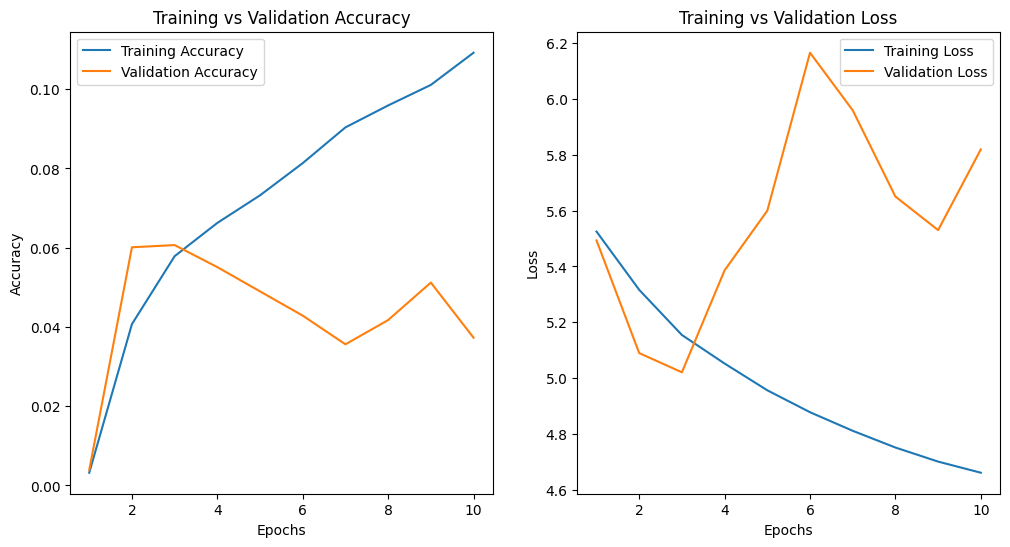

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plotting Training and Validation Accuracy and Loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



## Test Tiny com mixup

In [ ]:
batch_size = 32
image_size = (224, 224)
num_epochs = 30


preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

augment_mode='mixup'

# Carregamento dos datasets
train_ds, class_names = preprocess.load_img(
    data_dir="data/rare_species/train",
    minority_class=minority_class,
    augment=augment_mode if augment_mode != "none" else None,
    oversampling=True,
    shuffle=True
)

val_ds, _ = preprocess.load_img(
    data_dir="data/rare_species/val",
    minority_class=minority_class,
    augment=None,
    oversampling=False
)


steps_per_epoch = len(train_ds)
print(f"Number of batches per epoch: {steps_per_epoch}")

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Number of batches per epoch: 350


In [ ]:
model = build_densenet(
        layers_per_block=[4, 8, 12, 8],
        growth_rate=12,
        compression=0.5,
        dropout_rate=0.1,  # Menor dropout para baseline
        bottleneck=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),
            metrics=metrics)

In [ ]:
# Experimento
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"densenet_mix_tiny",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(
    callbacks=callbacks,
    epochs=num_epochs
)

No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 135s 168ms/step - accuracy: 0.0513 - auc: 0.6144 - f1_macro: 0.0208 - f1_weighted: 0.0318 - loss: 5.4194 - top5_accuracy: 0.1352 - val_accuracy: 0.0506 - val_auc: 0.6458 - val_f1_macro: 0.0058 - val_f1_weighted: 0.0183 - val_loss: 5.2003 - val_top5_accuracy: 0.1102 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.0588 - auc: 0.6358 - f1_macro: 0.0099 - f1_weighted: 0.0226 - loss: 5.0972 - top5_accuracy: 0.1586 - val_accuracy: 0.0161 - val_auc: 0.5563 - val_f1_macro: 0.0074 - val_f1_weighted: 0.0108 - val_loss: 6.9901 - val_top5_accuracy: 0.0668 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.0698 - auc: 0.6577 - f1_macro: 0.0151 - f1_weighted: 0.0294 - loss: 4.9684 - top5_accuracy: 0.1845 - val_accuracy: 0.0278 - val_auc: 0.5969 - val_f1_macro: 0.0092 - val_f1_weighted: 0.0144 - val_loss: 6.7317 - val_top5_accuracy: 0

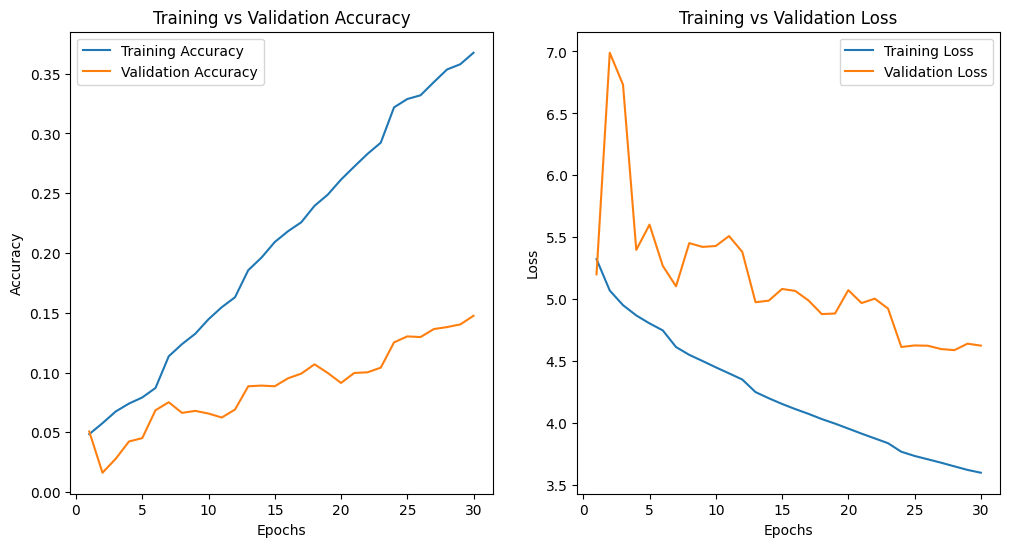

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plotting Training and Validation Accuracy and Loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [ ]:
model.save('dense_tiny_mix.h5')

## Test Increasing DropOut

In [ ]:
model = build_densenet(
        layers_per_block=[4, 8, 12, 8],
        growth_rate=12,
        compression=0.5,
        dropout_rate=0.3,
        bottleneck=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),
            metrics=metrics)

In [ ]:
# Experimento
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"densenet_mix_tiny_drop03",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(
    callbacks=callbacks,
    epochs=num_epochs
)

No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 115s 114ms/step - accuracy: 0.0709 - auc: 0.6324 - f1_macro: 0.0408 - f1_weighted: 0.0523 - loss: 5.4136 - top5_accuracy: 0.1707 - val_accuracy: 0.0501 - val_auc: 0.6580 - val_f1_macro: 0.0046 - val_f1_weighted: 0.0145 - val_loss: 5.1386 - val_top5_accuracy: 0.1575 - learning_rate: 0.0010
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.0549 - auc: 0.6340 - f1_macro: 0.0075 - f1_weighted: 0.0200 - loss: 5.1190 - top5_accuracy: 0.1556 - val_accuracy: 0.0479 - val_auc: 0.6720 - val_f1_macro: 0.0066 - val_f1_weighted: 0.0228 - val_loss: 5.1145 - val_top5_accuracy: 0.1603 - learning_rate: 0.0010
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.0641 - auc: 0.6574 - f1_macro: 0.0121 - f1_weighted: 0.0260 - loss: 4.9895 - top5_accuracy: 0.1783 - val_accuracy: 0.0595 - val_auc: 0.7119 - val_f1_macro: 0.0130 - val_f1_weighted: 0.0318 - val_loss: 4.9155 - val_top5_accuracy: 0

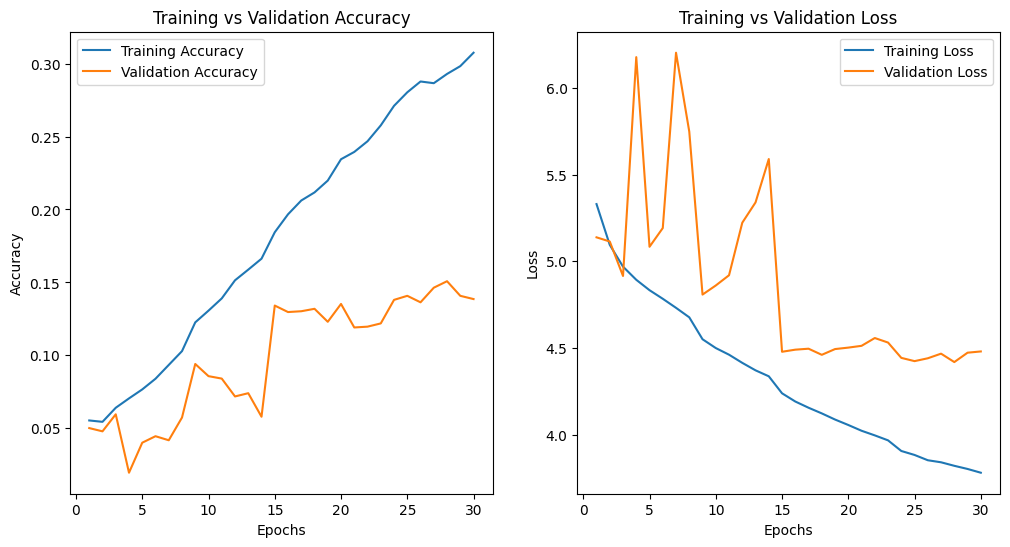

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plotting Training and Validation Accuracy and Loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [ ]:
model.save('model.h5')

## Hyperband tunner - DenseNet S

Testing:
- Drop out (different percentages)
- Growth rate
- Compression
- l2 weights
- Activation function

In [ ]:
def dense_layer(x, growth_rate, dropout_rate, bottleneck):
    # ‑‑ Optionally add a 1×1 bottleneck (DenseNet‑B)
    if bottleneck:
        x1 = BatchNormalization()(x)
        x1 = ReLU()(x1)
        x1 = Conv2D(4 * growth_rate, (1, 1), padding='same',
                    kernel_regularizer=l2(1e-4))(x1)
        x1 = BatchNormalization()(x1)
        x1 = ReLU()(x1)
        x1 = Conv2D(growth_rate, (3, 3), padding='same',
                    kernel_regularizer=l2(1e-4))(x1)
    else:
        x1 = BatchNormalization()(x)
        x1 = ReLU()(x1)
        x1 = Conv2D(growth_rate, (3, 3), padding='same',
                    kernel_regularizer=l2(1e-4))(x1)

    if dropout_rate:                    # dropout depois do conv
        x1 = Dropout(dropout_rate)(x1)
    return Concatenate()([x, x1])       # dense connection


def dense_block(x, n_layers, growth_rate, dropout_rate, bottleneck):
    for _ in range(n_layers):
        x = dense_layer(x, growth_rate, dropout_rate, bottleneck)
    return x


def transition_layer(x, compression, dropout_rate):
    filters = int(tf.keras.backend.int_shape(x)[-1] * compression)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (1, 1), padding='same',
               kernel_regularizer=l2(1e-4))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return AveragePooling2D((2, 2), strides=2)(x)


def build_densenet(input_shape=(224, 224, 3),
                   num_classes=202,
                   layers_per_block=(6, 12, 24, 16),
                   growth_rate=32,
                   compression=0.5,
                   bottleneck=True,
                   dropout_rate=0.3):
    inputs = Input(shape=input_shape)

    # Stem
    x = Conv2D(64, (7, 7), strides=2, padding='same',
               kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D((3, 3), strides=2, padding='same')(x)

    # Dense blocks
    for i, n_layers in enumerate(layers_per_block):
        x = dense_block(x, n_layers, growth_rate, dropout_rate, bottleneck)
        if i != len(layers_per_block) - 1:          # no transition after last
            x = transition_layer(x, compression, dropout_rate)

    # Classifier
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.3 MB/s eta 0:00:00


In [ ]:
from keras_tuner import Hyperband, Objective

In [ ]:
# Define OverfitStopper callback
class OverfitStopper(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.1):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        train_f1 = logs.get("f1_macro")  # adjust if your training metric has another name
        val_f1 = logs.get("val_f1_macro")
        if train_f1 is not None and val_f1 is not None:
            gap = train_f1 - val_f1
            if gap > self.threshold:
                print(f"[Early stop] Overfitting detected: train_f1={train_f1:.3f}, val_f1={val_f1:.3f}")
                self.model.stop_training = True

In [ ]:
# Model builder
def build_model_S_densenet(hp):
    growth_rate = hp.Choice('growth_rate', [12, 24, 32])
    compression = hp.Choice('compression', [0.5, 0.7, 1.0])
    dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
    learning_rate = hp.Float('lr', 1e-5, 1e-2, sampling='log')
    use_extra_dense = hp.Boolean('use_extra_dense')
    head_activation = hp.Choice("head_activation", ["relu", "leaky_relu"])

    print(f"[HP] growth_rate={growth_rate}, compression={compression}, dropout={dropout_rate}, "
          f"lr={learning_rate}, extra_dense={use_extra_dense}, activation={head_activation}")

    base_model = build_densenet(
        layers_per_block=[6, 12, 24, 16],
        growth_rate=growth_rate,
        compression=compression,
        dropout_rate=dropout_rate,
        bottleneck=True
    )

    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=True)

    # Head com ativação escolhida

    if use_extra_dense:
        x = layers.Dense(256)(x)
        if head_activation == 'leaky_relu':
            x = layers.LeakyReLU()(x)
        else:
            x = layers.ReLU()(x)
        x = layers.Dropout(dropout_rate)(x)  # regularização também aqui

    outputs = layers.Dense(202, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=metrics
    )

    return model

In [ ]:
# Custom tuner with augmentation and overfit control
class MyAugTuner(Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        aug = "mixup"
        oversample = True

        train_ds, _ = preprocess.load_img(
            data_dir="data/rare_species/train",
            minority_class=minority_class,
            augment=aug,
            oversampling=oversample,
            shuffle=True
        )

        val_ds, _ = preprocess.load_img(
            data_dir="data/rare_species/val",
            minority_class=minority_class,
            augment=None,
            oversampling=False
        )

        model = build_model_S_densenet(hp)
        epochs = trial.hyperparameters.get('tuner/epochs')

        return model.fit(
            train_ds,
            validation_data=val_ds,
            callbacks=callbacks,
            epochs=epochs,
            verbose=1
        )

In [ ]:
# Preprocessing
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

callbacks = callbacks + [OverfitStopper()]

# Tuner
tuner = MyAugTuner(
    hypermodel=build_model_S_densenet,
    objective=Objective("val_f1_macro", direction="max"),
    max_epochs=20,
    factor=3,
    directory="tuner_dir",
    project_name="densenet_S_mixup_control_overfit"
)

# Search
tuner.search(callbacks=callbacks)

Trial 15 Complete [00h 11m 59s]
val_f1_macro: 0.0017770847771316767

Best val_f1_macro So Far: 0.0017770847771316767
Total elapsed time: 02h 43m 02s

Search: Running Trial #16

Value             |Best Value So Far |Hyperparameter
12                |12                |growth_rate
0.7               |1                 |compression
0.1               |0.3               |dropout_rate
0.0098992         |2.0807e-05        |lr
False             |False             |use_extra_dense
relu              |relu              |head_activation
7                 |7                 |tuner/epochs
3                 |3                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
1                 |1                 |tuner/round
0000              |0009              |tuner/trial_id

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
[HP] growth_rate=12, compression=0.7, dropout=0.1, lr=0.009899233148540992, extra_dense=False, activation=relu
Epoch 1/

In [ ]:
# Retrieve the top N trials and print their results
top_n = 10
top_hps = tuner.get_best_hyperparameters(top_n)

for i, hp in enumerate(top_hps):
    matched_trial = None
    for trial in tuner.oracle.trials.values():
        if trial.hyperparameters.values == hp.values:
            matched_trial = trial
            break

    if matched_trial is None:
        print(f"\n No trial found for top {i+1}")
        continue

    print(f"\n🔹 Top {i+1} trial (Score: {matched_trial.score:.4f}):")

    print("  Growth Rate:", hp.get("growth_rate"))
    print("  Compression:", hp.get("compression"))
    print("  Dropout Rate:", hp.get("dropout_rate"))
    print("  Learning Rate:", hp.get("lr"))
    print("  Extra Dense:", hp.get("use_extra_dense"))
    print("  Head Activation:", hp.get("head_activation"))


## Hyperband Tuner - Tiny Dense Net

In [ ]:
def dense_layer(x, growth_rate, dropout_rate, bottleneck):
    # ‑‑ Optionally add a 1×1 bottleneck (DenseNet‑B)
    if bottleneck:
        x1 = BatchNormalization()(x)
        x1 = ReLU()(x1)
        x1 = Conv2D(4 * growth_rate, (1, 1), padding='same',
                    kernel_regularizer=l2(1e-4))(x1)
        x1 = BatchNormalization()(x1)
        x1 = ReLU()(x1)
        x1 = Conv2D(growth_rate, (3, 3), padding='same',
                    kernel_regularizer=l2(1e-4))(x1)
    else:
        x1 = BatchNormalization()(x)
        x1 = ReLU()(x1)
        x1 = Conv2D(growth_rate, (3, 3), padding='same',
                    kernel_regularizer=l2(1e-4))(x1)

    if dropout_rate:                    # dropout depois do conv
        x1 = Dropout(dropout_rate)(x1)
    return Concatenate()([x, x1])       # dense connection


def dense_block(x, n_layers, growth_rate, dropout_rate, bottleneck):
    for _ in range(n_layers):
        x = dense_layer(x, growth_rate, dropout_rate, bottleneck)
    return x


def transition_layer(x, compression, dropout_rate):
    filters = int(tf.keras.backend.int_shape(x)[-1] * compression)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (1, 1), padding='same',
               kernel_regularizer=l2(1e-4))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return AveragePooling2D((2, 2), strides=2)(x)


def build_densenet(input_shape=(224, 224, 3),
                   num_classes=202,
                   layers_per_block=(6, 12, 24, 16),
                   growth_rate=32,
                   compression=0.5,
                   bottleneck=True,
                   dropout_rate=0.3):
    inputs = Input(shape=input_shape)

    # Stem
    x = Conv2D(64, (7, 7), strides=2, padding='same',
               kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D((3, 3), strides=2, padding='same')(x)

    # Dense blocks
    for i, n_layers in enumerate(layers_per_block):
        x = dense_block(x, n_layers, growth_rate, dropout_rate, bottleneck)
        if i != len(layers_per_block) - 1:          # no transition after last
            x = transition_layer(x, compression, dropout_rate)

    # Classifier
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
from keras_tuner import Hyperband, Objective

In [ ]:
# Define OverfitStopper callback
class OverfitStopper(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.1):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        train_f1 = logs.get("f1_macro")  # adjust if your training metric has another name
        val_f1 = logs.get("val_f1_macro")
        if train_f1 is not None and val_f1 is not None:
            gap = train_f1 - val_f1
            if gap > self.threshold:
                print(f"[Early stop] Overfitting detected: train_f1={train_f1:.3f}, val_f1={val_f1:.3f}")
                self.model.stop_training = True

In [ ]:
# Model builder
def build_model_tiny_densenet(hp):

    growth_rate = hp.Choice('growth_rate', [8, 12, 16])
    compression = hp.Choice('compression', [0.4, 0.5, 0.6])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[5e-4, 1e-4])
    label_smoothing = hp.Choice('label_smoothing', [0.0, 0.05, 0.1])

    print(f"[HP] growth_rate={growth_rate}, compression={compression}, dropout={dropout_rate}, "
          f"lr={learning_rate}, label_smothing={label_smoothing}")



    base_model = build_densenet(
        layers_per_block=[4, 8, 12, 8],
        growth_rate=growth_rate,
        compression=compression,
        dropout_rate=dropout_rate,
        bottleneck=False
    )

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    base_model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        metrics=metrics
    )

    return base_model


In [ ]:
# Custom tuner with augmentation and overfit control
class MyAugTuner(Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        aug = "mixup"
        oversample = True

        train_ds, _ = preprocess.load_img(
            data_dir="data/rare_species/train",
            minority_class=minority_class,
            augment=aug,
            oversampling=oversample,
            shuffle=True
        )

        val_ds, _ = preprocess.load_img(
            data_dir="data/rare_species/val",
            minority_class=minority_class,
            augment=None,
            oversampling=False
        )

        model = build_model_tiny_densenet(hp)
        epochs = trial.hyperparameters.get('tuner/epochs')

        return model.fit(
            train_ds,
            validation_data=val_ds,
            callbacks=callbacks,
            epochs=epochs,
            verbose=1
        )

In [ ]:
# Preprocessing
batch_size = 32
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

callbacks = callbacks + [OverfitStopper()]

# Tuner
tuner = MyAugTuner(
    hypermodel=build_model_tiny_densenet,
    objective=Objective("val_f1_macro", direction="max"),
    max_epochs=20,
    factor=3,
    directory="tuner_dir",
    project_name="densenet_tiny_mixup_control_overfit_tuner"
)

# Search
tuner.search(callbacks=callbacks)

Trial 30 Complete [00h 09m 28s]
val_f1_macro: 0.025979025289416313

Best val_f1_macro So Far: 0.04569309949874878
Total elapsed time: 02h 47m 32s


In [ ]:
# Retrieve the top N trials and print their results
top_n = 10
top_hps = tuner.get_best_hyperparameters(top_n)

for i, hp in enumerate(top_hps):
    matched_trial = None
    for trial in tuner.oracle.trials.values():
        if trial.hyperparameters.values == hp.values:
            matched_trial = trial
            break

    if matched_trial is None:
        print(f"\n No trial found for top {i+1}")
        continue

    print(f"\n🔹 Top {i+1} trial (Score: {matched_trial.score:.4f}):")

    print("  Growth Rate:", hp.get("growth_rate"))
    print("  Compression:", hp.get("compression"))
    print("  Dropout Rate:", hp.get("dropout_rate"))
    print("  Learning Rate:", hp.get("learning_rate"))
    print("  Label Smoothing:", hp.get("label_smoothing"))


🔹 Top 1 trial (Score: 0.0457):
  Growth Rate: 8
  Compression: 0.4
  Dropout Rate: 0.30000000000000004
  Learning Rate: 0.0005
  Label Smoothing: 0.0

🔹 Top 2 trial (Score: 0.0456):
  Growth Rate: 12
  Compression: 0.5
  Dropout Rate: 0.30000000000000004
  Learning Rate: 0.0001
  Label Smoothing: 0.0

🔹 Top 3 trial (Score: 0.0420):
  Growth Rate: 16
  Compression: 0.4
  Dropout Rate: 0.2
  Learning Rate: 0.0005
  Label Smoothing: 0.05

🔹 Top 4 trial (Score: 0.0360):
  Growth Rate: 8
  Compression: 0.4
  Dropout Rate: 0.30000000000000004
  Learning Rate: 0.0005
  Label Smoothing: 0.0

🔹 Top 5 trial (Score: 0.0311):
  Growth Rate: 8
  Compression: 0.5
  Dropout Rate: 0.2
  Learning Rate: 0.0005
  Label Smoothing: 0.0

🔹 Top 6 trial (Score: 0.0280):
  Growth Rate: 8
  Compression: 0.5
  Dropout Rate: 0.30000000000000004
  Learning Rate: 0.0001
  Label Smoothing: 0.0

🔹 Top 7 trial (Score: 0.0260):
  Growth Rate: 8
  Compression: 0.4
  Dropout Rate: 0.30000000000000004
  Learning Rate: 0.

## DenseNet S after Hyperband - 30 epochs

In [ ]:
model=build_densenet(
    layers_per_block=[6, 12, 24, 16],
    growth_rate=12,
    compression=1,
    dropout_rate=0.3,
    bottleneck=True
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2.0807e-05),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),
        metrics=metrics)

In [ ]:
# Hiperparâmetros
batch_size = 32
image_size = (224, 224)
num_epochs = 30
augment_mode = "mixup"

# Preprocessador
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)
all_results = []


# Carregamento dos datasets
train_ds, class_names = preprocess.load_img(
    data_dir="data/rare_species/train",
    minority_class=minority_class,
    augment=augment_mode if augment_mode != "none" else None,
    oversampling=True,
    shuffle=True
)

val_ds, _ = preprocess.load_img(
    data_dir="data/rare_species/val",
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [ ]:
# Experimento
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"densenet_mix_S_test1",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(
    callbacks=callbacks,
    epochs=num_epochs
)

No checkpoint found, starting from scratch.
Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 782s 2s/step - accuracy: 0.0185 - auc: 0.5399 - f1_macro: 0.0020 - f1_weighted: 0.0058 - loss: 6.0166 - top5_accuracy: 0.0639 - val_accuracy: 0.0345 - val_auc: 0.5975 - val_f1_macro: 0.0021 - val_f1_weighted: 0.0099 - val_loss: 5.8590 - val_top5_accuracy: 0.1196 - learning_rate: 2.0807e-05
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 62s 176ms/step - accuracy: 0.0579 - auc: 0.6214 - f1_macro: 0.0036 - f1_weighted: 0.0129 - loss: 5.7835 - top5_accuracy: 0.1393 - val_accuracy: 0.0607 - val_auc: 0.6770 - val_f1_macro: 0.0051 - val_f1_weighted: 0.0208 - val_loss: 5.6214 - val_top5_accuracy: 0.1758 - learning_rate: 2.0807e-05
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 62s 177ms/step - accuracy: 0.0599 - auc: 0.6370 - f1_macro: 0.0040 - f1_weighted: 0.0137 - loss: 5.7276 - top5_accuracy: 0.1507 - val_accuracy: 0.0634 - val_auc: 0.6982 - val_f1_macro: 0.0089 - val_f1_weighted: 0.0251 - val_loss: 5.5609 - val_top5_accu

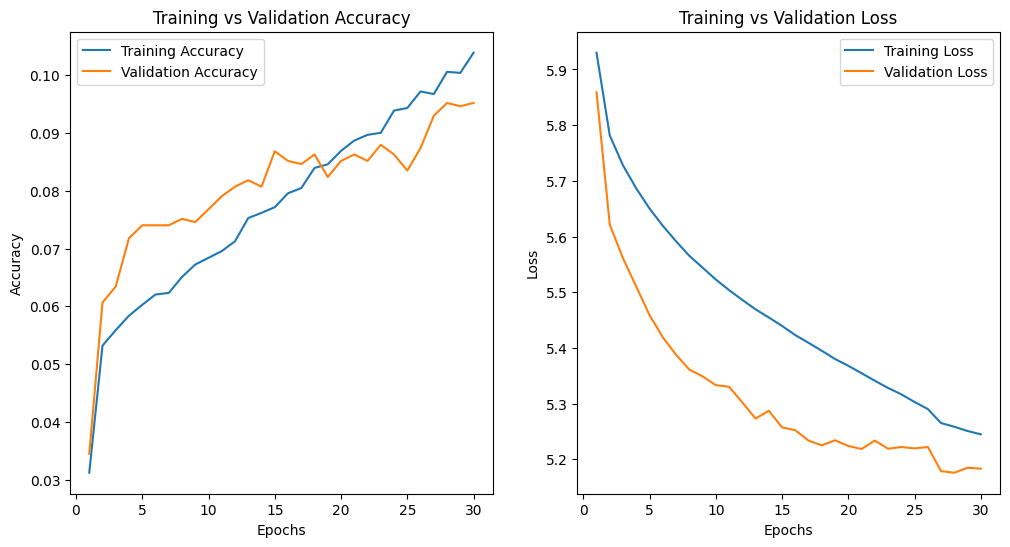

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plotting Training and Validation Accuracy and Loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [ ]:
model.save('densenet_s_test1.h5')

## DenseNet S after Hyperband - 100 epochs


In [ ]:
model=build_densenet(
    layers_per_block=[6, 12, 24, 16],
    growth_rate=12,
    compression=1,
    dropout_rate=0.3,
    bottleneck=True
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2.0807e-05),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),
        metrics=metrics)

In [ ]:
# Hiperparâmetros
batch_size = 32
image_size = (224, 224)
num_epochs = 100
augment_mode = "mixup"

# Preprocessador
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)
all_results = []


# Carregamento dos datasets
train_ds, class_names = preprocess.load_img(
    data_dir="data/rare_species/train",
    minority_class=minority_class,
    augment=augment_mode if augment_mode != "none" else None,
    oversampling=True,
    shuffle=True
)

val_ds, _ = preprocess.load_img(
    data_dir="data/rare_species/val",
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [ ]:
# Experimento
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"densenet_mix_S_test2",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(
    callbacks=callbacks,
    epochs=num_epochs
)

No checkpoint found, starting from scratch.
Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 345s 321ms/step - accuracy: 0.0447 - auc: 0.6061 - f1_macro: 0.0175 - f1_weighted: 0.0293 - loss: 5.9854 - top5_accuracy: 0.1279 - val_accuracy: 0.0323 - val_auc: 0.6052 - val_f1_macro: 0.0028 - val_f1_weighted: 0.0127 - val_loss: 5.8531 - val_top5_accuracy: 0.1029 - learning_rate: 2.0807e-05
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 66s 187ms/step - accuracy: 0.0560 - auc: 0.6200 - f1_macro: 0.0043 - f1_weighted: 0.0136 - loss: 5.7405 - top5_accuracy: 0.1484 - val_accuracy: 0.0735 - val_auc: 0.6973 - val_f1_macro: 0.0071 - val_f1_weighted: 0.0239 - val_loss: 5.5440 - val_top5_accuracy: 0.1925 - learning_rate: 2.0807e-05
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 65s 186ms/step - accuracy: 0.0599 - auc: 0.6367 - f1_macro: 0.0063 - f1_weighted: 0.0168 - loss: 5.6595 - top5_accuracy: 0.1617 - val_accuracy: 0.0801 - val_auc: 0.7161 - val_f1_macro: 0.0115 - val_f1_weighted: 0.0333 - val_loss: 5.4647 - val_top

In [ ]:
model.save('densenet_s_test2_100epc.h5')

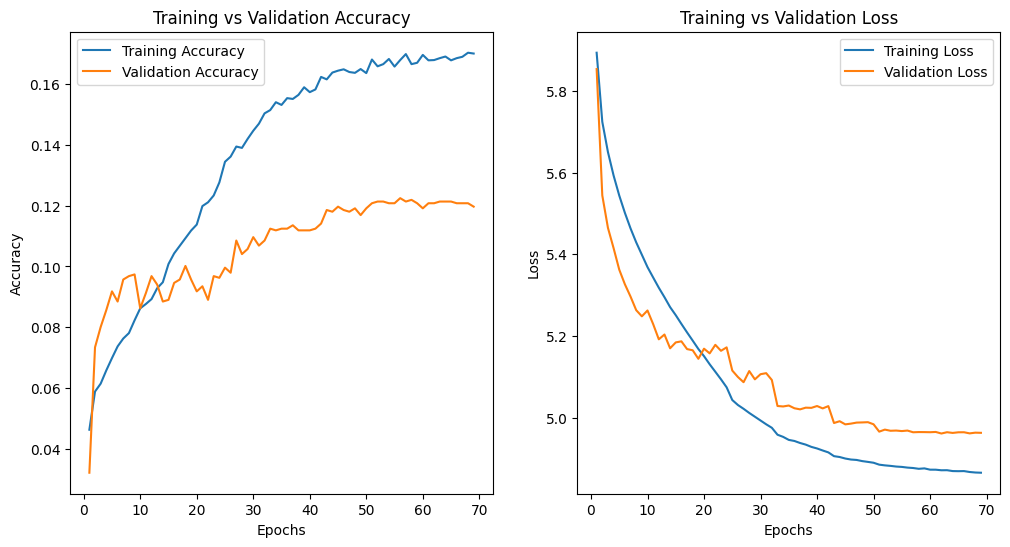

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plotting Training and Validation Accuracy and Loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



## 1st DenseNet Tiny after hyperband

In [ ]:
model=build_densenet(
    layers_per_block=[4, 8, 12, 8],
    growth_rate=8,
    compression=0.4,
    dropout_rate=0.3,
    bottleneck=False
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),
        metrics=metrics)

In [ ]:
# Hiperparâmetros
batch_size = 32
image_size = (224, 224)
num_epochs = 100
augment_mode = "mixup"

# Preprocessador
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)
all_results = []


# Carregamento dos datasets
train_ds, class_names = preprocess.load_img(
    data_dir="data/rare_species/train",
    minority_class=minority_class,
    augment=augment_mode if augment_mode != "none" else None,
    oversampling=True,
    shuffle=True
)

val_ds, _ = preprocess.load_img(
    data_dir="data/rare_species/val",
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [ ]:
# Experimento
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"densenet_mix_tiny_test1",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(
    callbacks=callbacks,
    epochs=num_epochs
)

No checkpoint found, starting from scratch.
Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 145s 178ms/step - accuracy: 0.0610 - auc: 0.6260 - f1_macro: 0.0133 - f1_weighted: 0.0263 - loss: 5.2764 - top5_accuracy: 0.1511 - val_accuracy: 0.0646 - val_auc: 0.6890 - val_f1_macro: 0.0062 - val_f1_weighted: 0.0223 - val_loss: 4.9673 - val_top5_accuracy: 0.1703 - learning_rate: 5.0000e-04
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.0617 - auc: 0.6391 - f1_macro: 0.0065 - f1_weighted: 0.0170 - loss: 5.0399 - top5_accuracy: 0.1600 - val_accuracy: 0.0534 - val_auc: 0.6751 - val_f1_macro: 0.0060 - val_f1_weighted: 0.0189 - val_loss: 5.0636 - val_top5_accuracy: 0.1658 - learning_rate: 5.0000e-04
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.0683 - auc: 0.6546 - f1_macro: 0.0104 - f1_weighted: 0.0227 - loss: 4.9580 - top5_accuracy: 0.1757 - val_accuracy: 0.0618 - val_auc: 0.6649 - val_f1_macro: 0.0125 - val_f1_weighted: 0.0339 - val_loss: 5.1933 - val_top5_

In [ ]:
model.save('densenet_tiny_test1.keras')

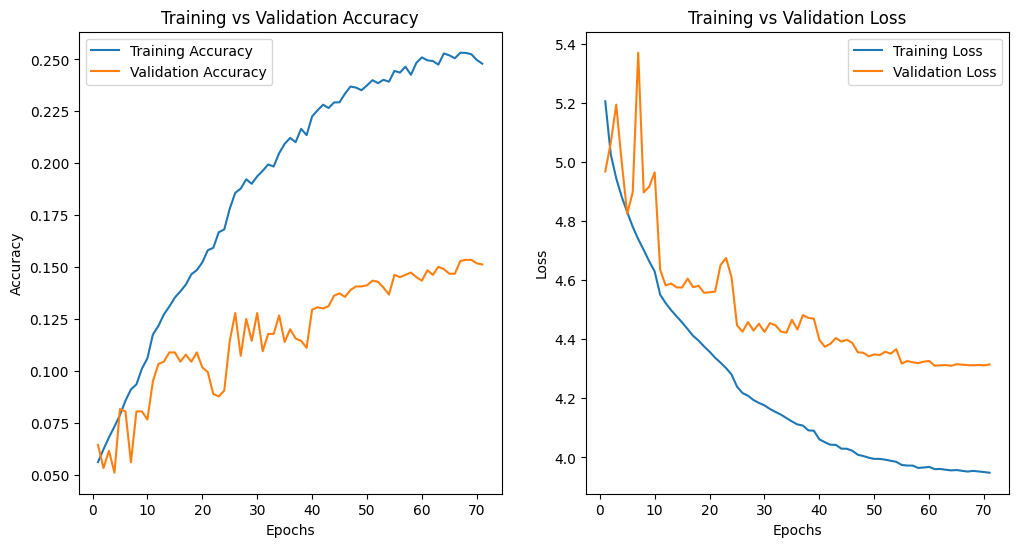

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plotting Training and Validation Accuracy and Loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## 2nd DenseNet tiny after hyperband

In [ ]:
model=build_densenet(
    layers_per_block=[4, 8, 12, 8],
    growth_rate=12,
    compression=0.5,
    dropout_rate=0.3,
    bottleneck=False
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),
        metrics=metrics)

In [ ]:
# Hiperparâmetros
batch_size = 32
image_size = (224, 224)
num_epochs = 100
augment_mode = "mixup"

# Preprocessador
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)
all_results = []


# Carregamento dos datasets
train_ds, class_names = preprocess.load_img(
    data_dir="data/rare_species/train",
    minority_class=minority_class,
    augment=augment_mode if augment_mode != "none" else None,
    oversampling=True,
    shuffle=True
)

val_ds, _ = preprocess.load_img(
    data_dir="data/rare_species/val",
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [ ]:
# Experimento
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"densenet_mix_tiny_test2",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(
    callbacks=callbacks,
    epochs=num_epochs
)

No checkpoint found, starting from scratch.
Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 151s 187ms/step - accuracy: 0.0758 - auc: 0.6346 - f1_macro: 0.0377 - f1_weighted: 0.0545 - loss: 5.3324 - top5_accuracy: 0.1749 - val_accuracy: 0.0406 - val_auc: 0.6308 - val_f1_macro: 0.0036 - val_f1_weighted: 0.0162 - val_loss: 5.2017 - val_top5_accuracy: 0.1447 - learning_rate: 1.0000e-04
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.0619 - auc: 0.6315 - f1_macro: 0.0054 - f1_weighted: 0.0167 - loss: 5.1092 - top5_accuracy: 0.1600 - val_accuracy: 0.0651 - val_auc: 0.6874 - val_f1_macro: 0.0083 - val_f1_weighted: 0.0211 - val_loss: 5.0038 - val_top5_accuracy: 0.1886 - learning_rate: 1.0000e-04
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.0673 - auc: 0.6487 - f1_macro: 0.0080 - f1_weighted: 0.0206 - loss: 5.0119 - top5_accuracy: 0.1827 - val_accuracy: 0.0651 - val_auc: 0.7083 - val_f1_macro: 0.0116 - val_f1_weighted: 0.0281 - val_loss: 4.9298 - val_top5_

In [ ]:
model.save('densenet_tiny_test2.keras')

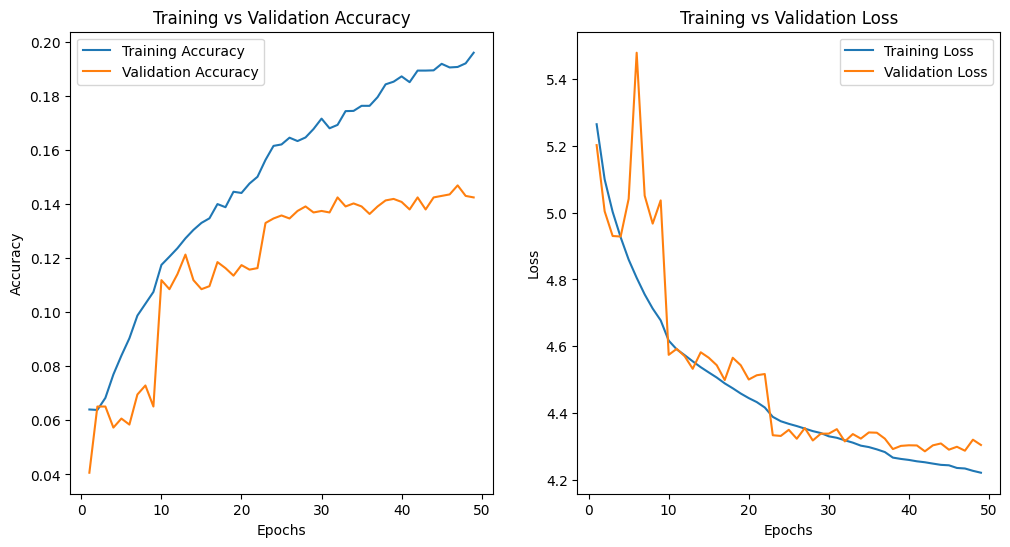

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plotting Training and Validation Accuracy and Loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## 3rd Dense Net Tiny after hyperband

In [ ]:
model=build_densenet(
    layers_per_block=[4, 8, 12, 8],
    growth_rate=16,
    compression=0.4,
    dropout_rate=0.2,
    bottleneck=False
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        metrics=metrics)

In [ ]:
# Hiperparâmetros
batch_size = 32
image_size = (224, 224)
num_epochs = 100
augment_mode = "mixup"

# Preprocessador
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)
all_results = []


# Carregamento dos datasets
train_ds, class_names = preprocess.load_img(
    data_dir="data/rare_species/train",
    minority_class=minority_class,
    augment=augment_mode if augment_mode != "none" else None,
    oversampling=True,
    shuffle=True
)

val_ds, _ = preprocess.load_img(
    data_dir="data/rare_species/val",
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [ ]:
# Experimento
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"densenet_mix_tiny_test3",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(
    callbacks=callbacks,
    epochs=num_epochs
)

No checkpoint found, starting from scratch.
Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 150s 186ms/step - accuracy: 0.0747 - auc: 0.6348 - f1_macro: 0.0312 - f1_weighted: 0.0458 - loss: 5.4032 - top5_accuracy: 0.1791 - val_accuracy: 0.0378 - val_auc: 0.6206 - val_f1_macro: 0.0031 - val_f1_weighted: 0.0111 - val_loss: 5.4078 - val_top5_accuracy: 0.1107 - learning_rate: 5.0000e-04
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.0572 - auc: 0.6365 - f1_macro: 0.0090 - f1_weighted: 0.0206 - loss: 5.1452 - top5_accuracy: 0.1583 - val_accuracy: 0.0289 - val_auc: 0.6071 - val_f1_macro: 0.0056 - val_f1_weighted: 0.0105 - val_loss: 6.2608 - val_top5_accuracy: 0.1085 - learning_rate: 5.0000e-04
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.0682 - auc: 0.6546 - f1_macro: 0.0152 - f1_weighted: 0.0285 - loss: 5.0232 - top5_accuracy: 0.1869 - val_accuracy: 0.0562 - val_auc: 0.6717 - val_f1_macro: 0.0176 - val_f1_weighted: 0.0313 - val_loss: 5.3343 - val_top5_

In [ ]:
model.save('densenet_tiny_test3.keras')

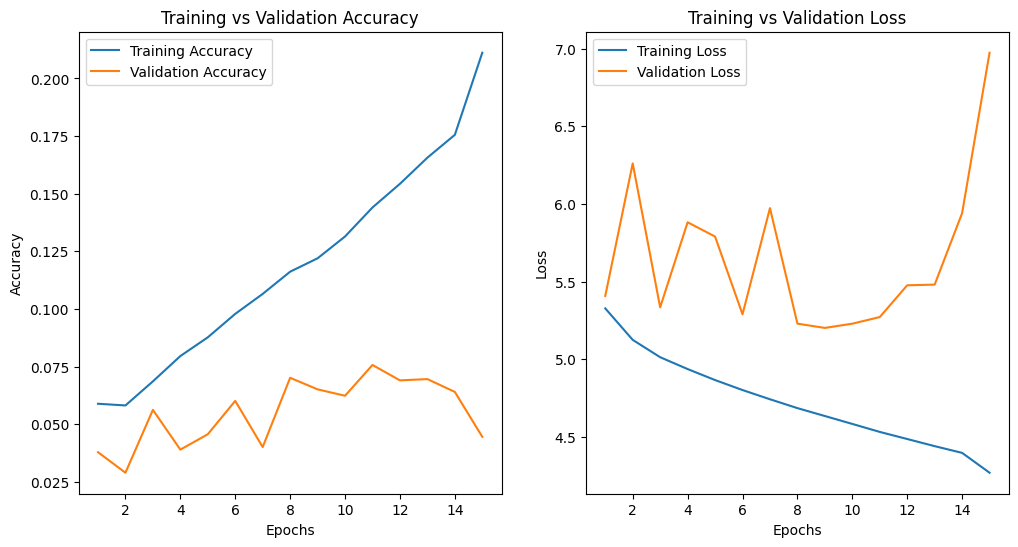

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plotting Training and Validation Accuracy and Loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## 2nd best with bottleneck

In [ ]:
model=build_densenet(
    layers_per_block=[4, 8, 12, 8],
    growth_rate=12,
    compression=0.5,
    dropout_rate=0.3,
    bottleneck=True
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),
        metrics=metrics)

In [ ]:
# Hiperparâmetros
batch_size = 32
image_size = (224, 224)
num_epochs = 100
augment_mode = "mixup"

# Preprocessador
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)
all_results = []


# Carregamento dos datasets
train_ds, class_names = preprocess.load_img(
    data_dir="data/rare_species/train",
    minority_class=minority_class,
    augment=augment_mode if augment_mode != "none" else None,
    oversampling=True,
    shuffle=True
)

val_ds, _ = preprocess.load_img(
    data_dir="data/rare_species/val",
    minority_class=minority_class,
    augment=None,
    oversampling=False
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [ ]:
# Experimento
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name=f"densenet_mix_tiny_test2_bottleneck",
    batch_size=batch_size,
    image_size=image_size,
    save_model=False
)

history = experiment.run_experiment(
    callbacks=callbacks,
    epochs=num_epochs
)

No checkpoint found, starting from scratch.
Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 201s 198ms/step - accuracy: 0.0364 - auc: 0.5910 - f1_macro: 0.0114 - f1_weighted: 0.0201 - loss: 5.5552 - top5_accuracy: 0.1065 - val_accuracy: 0.0334 - val_auc: 0.6361 - val_f1_macro: 0.0020 - val_f1_weighted: 0.0082 - val_loss: 5.4085 - val_top5_accuracy: 0.1347 - learning_rate: 1.0000e-04
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.0634 - auc: 0.6218 - f1_macro: 0.0044 - f1_weighted: 0.0146 - loss: 5.3551 - top5_accuracy: 0.1524 - val_accuracy: 0.0768 - val_auc: 0.6956 - val_f1_macro: 0.0113 - val_f1_weighted: 0.0326 - val_loss: 5.1461 - val_top5_accuracy: 0.2081 - learning_rate: 1.0000e-04
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.0636 - auc: 0.6396 - f1_macro: 0.0052 - f1_weighted: 0.0161 - loss: 5.2668 - top5_accuracy: 0.1684 - val_accuracy: 0.0690 - val_auc: 0.6924 - val_f1_macro: 0.0106 - val_f1_weighted: 0.0279 - val_loss: 5.1687 - val_top5_

In [ ]:
model.save('densenet_tiny_test2_bottleneck.keras')

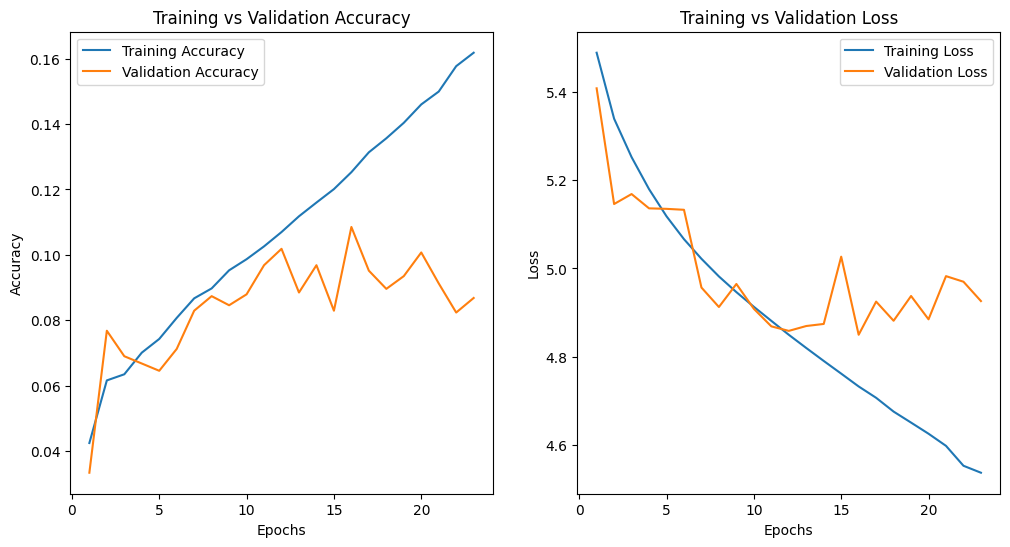

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plotting Training and Validation Accuracy and Loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
